此程式馬用於對ECCE2025的Zero NG paper 進行開發

In [2]:

# import used functioons 
#  import tools 
%matplotlib widget
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Conv1D, Dense, concatenate, RepeatVector, MaxPooling1D, Activation ,UpSampling1D, Conv1DTranspose, Concatenate
from tensorflow.keras.utils import plot_model

import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU devices found:")
    for gpu in gpus:
        print(gpu)
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

import numpy as np 
import pandas as pd
from openpyxl import Workbook
import matplotlib.pyplot as plt
import os
import sys
import csv
import time
from IPython import embed

from rul_features.rul_data_read import read_rul_data

from test_algs.CCAE_ntu_rul import get_initial_files_datalist, CCAE_train
from test_algs.CCAE_ntu_rul import CCAE_model_application, CCAE_model_build_train

# Data set folder 
NTU_dataset_path = r'D:\OneDrive\CCAE_experiments\CCAE_datasets'

# Normal_data_path = os.path.join(NTU_dataset_path, 'Normal')

Normal_data_path = os.path.join(NTU_dataset_path, 'Normal2')


# 列出此資料夾的所有子資料夾
Normal_subfolders = [f.path for f in os.scandir(Normal_data_path) if f.is_dir()]

Fault_data_path = os.path.join(NTU_dataset_path, 'Wearout2')


GPU devices found:
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


確認估測器狀態

In [3]:
def estimate_torque(data_read, speed_v=1800, debug=False):

    """
    Estimate the motor torque based on voltage and current inputs.
    :param v_a_raw: Voltage alpha component
    :param v_b_raw: Voltage beta component
    :param i_alpha: Current alpha component
    :param i_beta: Current beta component
    :param speed_v: Motor speed in rpm (default: 900)
    :param debug: Boolean flag to enable debugging plots (default: False)
    :return: Estimated torque array
    """

    v_a_raw = np.array(data_read["Voltage alpha downsample"])
    v_c_raw = np.array(data_read["Voltage beta downsample"])
    i_alpha = np.array(data_read["Current alpha"])
    i_beta  = np.array(data_read["Current beta"])

    # offset calibration
    v_a_raw = v_a_raw - np.mean(v_a_raw)
    v_c_raw = v_c_raw - np.mean(v_c_raw)
    i_alpha = i_alpha - np.mean(i_alpha)
    i_beta = i_beta - np.mean(i_beta)

    # Preprocess the voltage data, transform the data to alpha-beta frame
    v_alpha = v_a_raw
    v_beta = v_c_raw
    
    class EMF:
        def __init__(self):
            self.Alpha = 0.0
            self.Beta = 0.0
            self.Alpha_last = 0.0
            self.Beta_last = 0.0
            self.Alpha_LPF = 0.0
            self.Beta_LPF = 0.0
            self.Alpha_LPF_last = 0.0
            self.Beta_LPF_last = 0.0

    def emf_to_lpf(sampling_time, lpf_radius, emf_obj):
        lpf_radius_t = lpf_radius * sampling_time
        emf_coef1 = sampling_time / (lpf_radius_t + 2)
        emf_coef2 = (lpf_radius_t - 2) / (lpf_radius_t + 2)

        emf_obj.Alpha_LPF = emf_coef1 * (emf_obj.Alpha_last + emf_obj.Alpha) - emf_coef2 * emf_obj.Alpha_LPF_last
        emf_obj.Beta_LPF = emf_coef1 * (emf_obj.Beta_last + emf_obj.Beta) - emf_coef2 * emf_obj.Beta_LPF_last

        emf_obj.Alpha_last = emf_obj.Alpha
        emf_obj.Beta_last = emf_obj.Beta

        emf_obj.Alpha_LPF_last = emf_obj.Alpha_LPF
        emf_obj.Beta_LPF_last = emf_obj.Beta_LPF

    def flux_comp(omega_e, lpf_radius):
        if np.abs(omega_e) < 1:
            mag_comp = 1.0
        else:
            mag_comp = np.abs(omega_e) / np.sqrt(omega_e ** 2 + lpf_radius ** 2)

        phase_comp = -57.29578 * np.arctan2(lpf_radius, omega_e) / 360  # Degree to radians conversion

        return mag_comp, phase_comp

    # Compute necessary parameters
    fs = 20000 # Sampling rate
    flux_rs = 12.5  # Motor stator resistance
    tsim = 1 / fs  # Time step

    we = (speed_v / 60) * (np.pi * 2)*4 # electrical angular velocity
    coef = 0.2
    cross_freq = 15.0

    intgr_bw_f = max((we / (np.pi * 2)) * coef, cross_freq)
    fast_wc = intgr_bw_f * (np.pi * 2)

    # Process each time step
    emf1 = EMF()
    alpha_lpf_values, beta_lpf_values = [], []
    alpha_raw_values, beta_raw_values = [], []

    for va, vb, ia, ib in zip(v_alpha, v_beta, i_alpha, i_beta):
        emf1.Alpha = va - (ia * flux_rs)
        emf1.Beta = vb - (ib * flux_rs)
        alpha_raw_values.append(emf1.Alpha)
        beta_raw_values.append(emf1.Beta)
        emf_to_lpf(tsim, fast_wc, emf1)
        alpha_lpf_values.append(emf1.Alpha_LPF)
        beta_lpf_values.append(emf1.Beta_LPF)

    # Flux compensation
    mag_comp2, phase_comp2 = flux_comp(we, fast_wc)

    # Apply phase and magnitude compensation
    alpha_compensated_values, beta_compensated_values = [], []
    for alpha, beta in zip(alpha_lpf_values, beta_lpf_values):
        ds = alpha * mag_comp2
        qs = beta * mag_comp2
        angle = phase_comp2
        sine, cosine = np.sin(angle), np.cos(angle)
        alpha_transformed = ds * cosine - qs * sine
        beta_transformed = qs * cosine + ds * sine
        alpha_compensated_values.append(alpha_transformed)
        beta_compensated_values.append(beta_transformed)

    # Torque estimation
    torque_v = 1.5 * 4 * ((np.array(alpha_compensated_values) * i_beta) - (np.array(beta_compensated_values) * i_alpha))
    torque_avg = np.mean(np.abs(torque_v[-500:]))
    # Power and efficiency estimation
    Power_M= torque_avg*speed_v*2*np.pi/60
    Power_E = 1.5*np.mean((v_alpha * i_alpha + v_beta * i_beta))
    efficiency = Power_M / Power_E * 100
    power_sts = {
        'Power_M': Power_M,
        'Power_E': Power_E,
        'Efficiency': efficiency,
        'Efficiency_alarm': int(efficiency < 90)
    }

    if debug :
        date_time=pd.to_datetime(data_read["Unix Time"], unit='s').strftime('%Y-%m-%d %H:%M:%S')

        print("Estimated Torque:", np.mean(torque_v[-500:]))
        # print result
        for key, value in power_sts.items():
            print(f"{key}: {value}")
        time = np.arange(len(v_alpha)) * tsim

        # plot the flux values
        plt.figure(figsize=(10, 5))
        plt.plot(time, alpha_compensated_values, label='Flux Alpha')
        plt.plot(time, beta_compensated_values, label='Flux Beta ')
        plt.xlabel('Time (s)')
        plt.ylabel('Flux Values')
        plt.legend()
        plt.title('Flux Values'+date_time)
        plt.grid()
        plt.show(block=False)

        # plot the voltage values
        plt.figure(figsize=(10, 5))
        plt.plot(time, v_alpha, label='Voltage Beta (raw)')
        plt.plot(time, v_beta, label='Voltage Beta (raw)')
        plt.xlabel('Time (s)')
        plt.ylabel('Voltage Values')
        plt.legend()
        plt.title('Voltage Values')
        plt.grid()
        plt.show(block=False)

        # plot the current values
        plt.figure(figsize=(10, 5))
        plt.plot(time, i_alpha, label='Current Alpha (raw)')
        plt.plot(time, i_beta, label='Current Beta (raw)')
        plt.xlabel('Time (s)')
        plt.ylabel('Current Values')
        plt.legend()
        plt.title('Current Values')
        plt.grid()
        plt.show(block=False)

        # plot the EMF values
        plt.figure(figsize=(10, 5))
        plt.plot(time, alpha_raw_values, label='EMF Alpha (raw)')
        plt.plot(time, beta_raw_values, label='EMF Beta (raw)')
        plt.xlabel('Time (s)')
        plt.ylabel('EMF Values')
        plt.legend()
        plt.title('EMF Values')
        plt.grid()
        plt.show(block=False)

        # plot torque estimation
        plt.figure(figsize=(10, 5))
        plt.plot(time, torque_v, label='Torque (Voltage Model)')
        
        plt.plot(time[-6000:], torque_v[-6000:], label='monitored torque region', color='red')
        torque_avg=np.mean(torque_v[-6000:])
            
        plt.axhline(y=torque_avg, color='k', linestyle='--', label='Averaged torque')
        plt.xlabel('Time (s)')
        plt.ylabel('Torque (N.m)')
        plt.legend()
        plt.title(f'Torque Estimation :{torque_avg:.2f} (N.m)')
        plt.grid()
        plt.show(block=False)

        fig, ax1 = plt.subplots(figsize=(10, 5))
        ax1.set_xlabel('Time (s)')
        ax1.set_ylabel('EMF Alpha (Raw)', color='tab:blue')
        ax1.plot(time, alpha_raw_values, label='EMF Alpha (Raw)', color='tab:blue')
        ax1.tick_params(axis='y', labelcolor='tab:blue')
        ax1.legend(loc='upper left')

        ax2 = ax1.twinx()
        ax2.set_ylabel('EMF Alpha (Filtered)', color='tab:red')
        # ax2.plot(time, alpha_lpf_values, label='EMF Alpha (Filtered)', color='tab:red')
        ax2.plot(time, alpha_compensated_values, label='EMF Alpha (Compensated)', color='tab:red')
        ax2.tick_params(axis='y', labelcolor='tab:red')
        ax2.legend(loc='upper right')

        plt.title('EMF Alpha - Raw vs Filtered')
        plt.grid()
        plt.show(block=False)
    # return the torque value and the estimated flux
    return torque_v, alpha_compensated_values, beta_compensated_values, v_alpha, v_beta, power_sts

files = [os.path.join(Normal_subfolders[0], f) for f in os.listdir(Normal_subfolders[0]) if f.endswith(".parquet")] 
observer_test_file=files[0]
df=read_rul_data(r"D:\OneDrive\CCAE_experiments\CCAE_datasets\drill 2X1\0531_1200_0_5V\RUL_Data_3_2.parquet")
print("Data read from file:", observer_test_file)
torque_v, alpha_compensated_values, beta_compensated_values, v_alpha, v_beta, power_sts=estimate_torque(df, speed_v=df["Speed"][0], debug=False)
print(len(df["Voltage alpha downsample"]))



Data read from file: D:\OneDrive\CCAE_experiments\CCAE_datasets\Normal2\0611_1200_0_5V\RUL_Data_3_1.parquet
8000


Current alpha downsample RMS: 0.011684970294197372


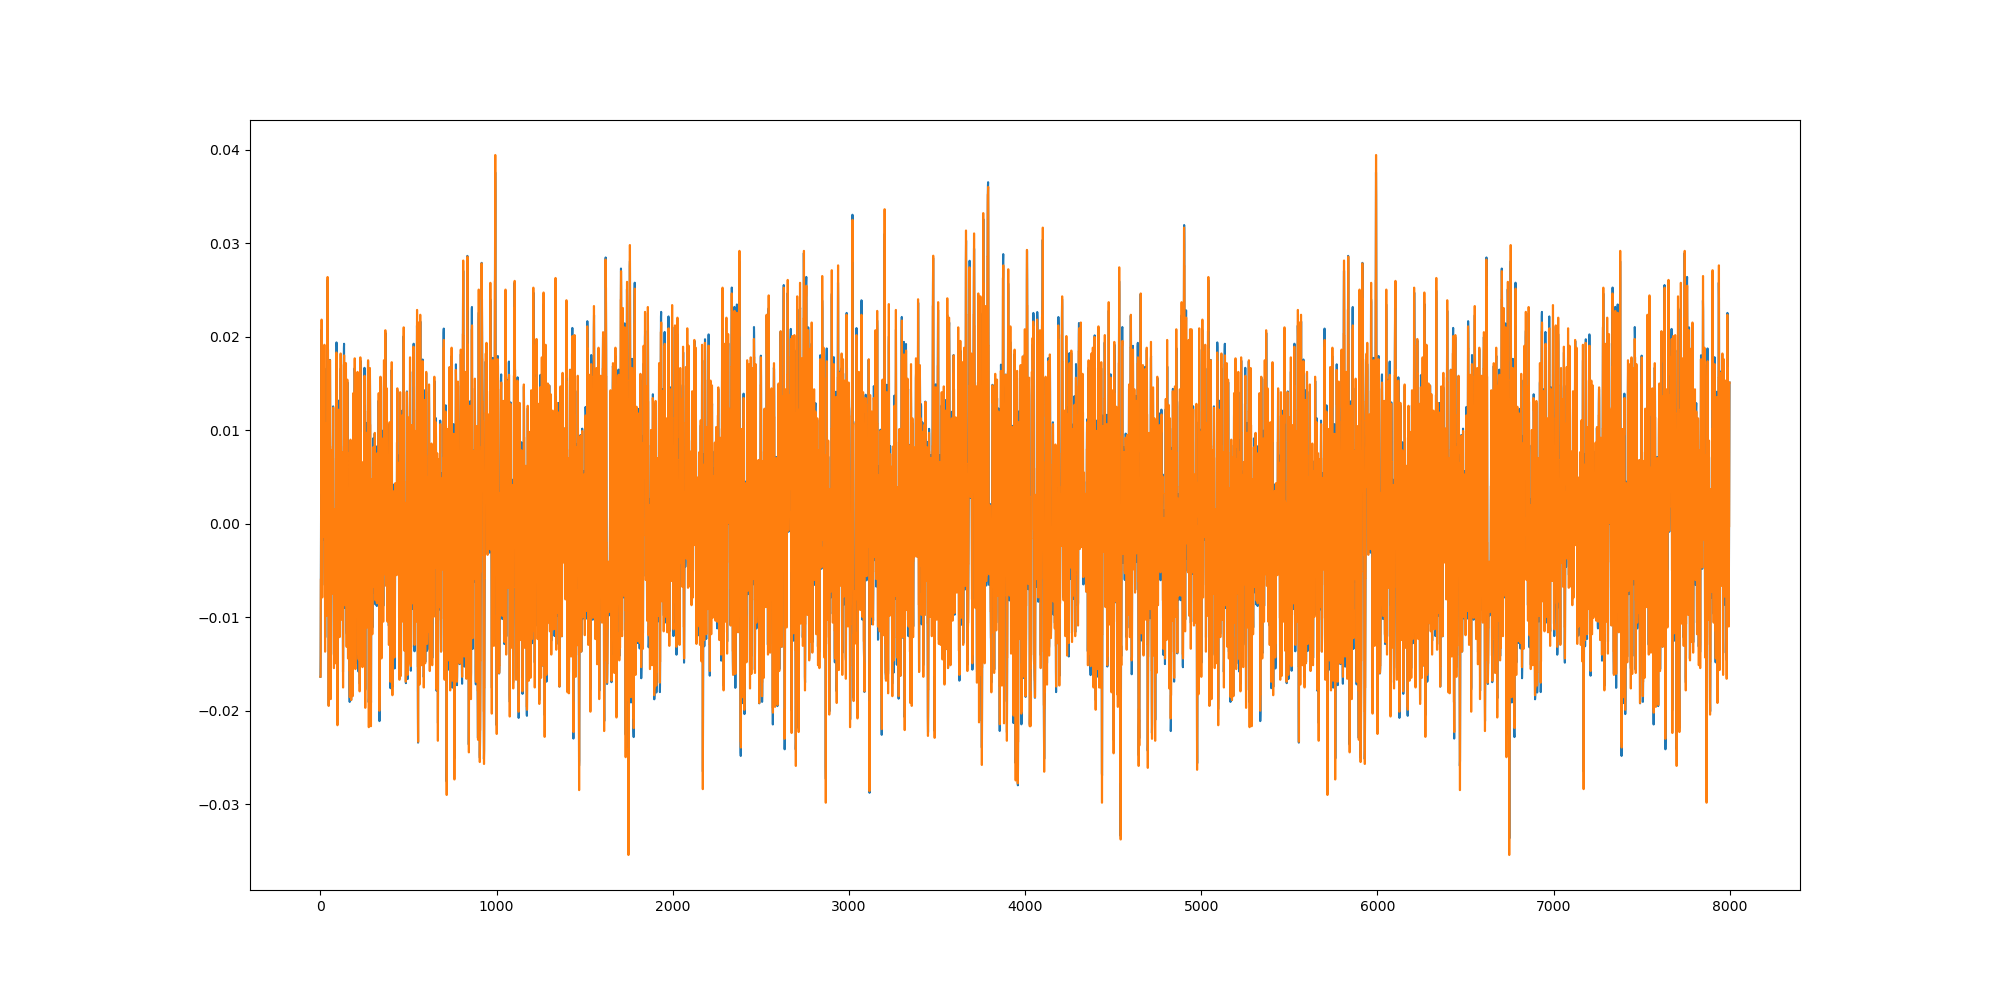

In [15]:

a=1
df=read_rul_data(r"D:\OneDrive\CCAE_experiments\CCAE_datasets\drill 2X1\0531_1200_0_5V\RUL_Data_3_1.parquet")
rms = np.sqrt(np.mean(np.square(df["Current alpha downsample"])))
print("Current alpha downsample RMS:", rms)
plt.figure(figsize=(20, 10))
plt.plot(df["Current alpha downsample"], label='Current Alpha Downsample')
plt.plot(df["Current alpha"], label='Current Alpha')



建立 condition based autoencoder 

In [ ]:

from datetime import datetime
import json
from tensorflow.keras.layers import Input, RepeatVector, Concatenate, Conv1D, MaxPooling1D, Activation, Dense, UpSampling1D, concatenate, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1DTranspose
import os


def build_ccae_model_middle_condition(input_dim_list, sequence_length, condition_dim, model_folder_path, model_name):
    """
    Build and save a CCAE model.
    將 condition 輸入改成兩個一維通道並在 decoder 前併入
    所有 layer 長度改成兩倍
    """
    inputs = []
    for idx, input_dim in enumerate(input_dim_list):
        input_layer = Input(shape=(sequence_length, input_dim), name=f'series_{idx}')
        inputs.append(input_layer)

    encoder_input = Concatenate(axis=-1, name='full_encoder_input')(inputs)
    x = Conv1D(filters=128, kernel_size=128, strides=32, padding='same')(encoder_input)
    x = MaxPooling1D(pool_size=4)(x)
    x = Activation('relu')(x)

    x = Conv1D(filters=64, kernel_size=6, padding='same')(x)
    x = MaxPooling1D(pool_size=4)(x)
    x = Activation('relu')(x)

    x = Conv1D(filters=32, kernel_size=6, padding='same')(x)
    x = MaxPooling1D(pool_size=4)(x)
    encoded = Activation('relu')(x)

    encoder_model = Model(inputs=inputs, outputs=encoded, name='Encoder')

    # condition 輸入為兩個一維通道
    condition_input_1 = Input(shape=(condition_dim,), name='condition_1')
    condition_input_2 = Input(shape=(condition_dim,), name='condition_2')

    # Decoder
    decoder_input = Input(shape=encoder_model.output_shape[1:], name='encoder_output')

    # 將兩個 condition 併入 decoder 前
    repeated_condition_1 = RepeatVector(decoder_input.shape[1])(condition_input_1)
    repeated_condition_2 = RepeatVector(decoder_input.shape[1])(condition_input_2)
    # Concatenate along the last axis (features)
    repeated_condition = Concatenate(axis=-1)([repeated_condition_1, repeated_condition_2])
    # Flatten and Dense to match decoder_input features
    repeated_condition = Dense(decoder_input.shape[2], activation='linear')(repeated_condition)
    decoder_merge_input = Concatenate(axis=-1, name='merged_decoder_input')([decoder_input, repeated_condition])

    x = Conv1DTranspose(filters=32, kernel_size=6, padding='same')(decoder_merge_input)
    x = UpSampling1D(4)(x)
    x = Activation('relu')(x)

    x = Conv1DTranspose(filters=64, kernel_size=6, padding='same')(x)
    x = UpSampling1D(4)(x)
    x = Activation('relu')(x)

    x = Conv1DTranspose(filters=128, kernel_size=128, strides=32, padding='same')(x)
    x = UpSampling1D(4)(x)
    x = Activation('tanh')(x)

    output_list = [Dense(dim, activation='linear', name=f'output_{idx}')(x) for idx, dim in enumerate(input_dim_list)]
    decoder_model = Model(inputs=[decoder_input, condition_input_1, condition_input_2], outputs=output_list, name='Decoder')

    encoded = encoder_model(inputs)
    decoder_outputs = decoder_model([encoded, condition_input_1, condition_input_2])

    model = Model(inputs=inputs + [condition_input_1, condition_input_2], outputs=decoder_outputs, name=f'CCAE_model{encoder_input.shape[2]}_in_{len(output_list)}_out')
    model.save(os.path.join(model_folder_path, "models", model_name))

    metadata = {
        "model_name": model_name,
        "input_dim_list": input_dim_list,
        "sequence_length": sequence_length,
        "condition_dim": condition_dim,
        "created_at": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "trained": False,
        "train_date": None,
        "condition_channels": 2
    }
    with open(os.path.join(model_folder_path, "model_inform", model_name.replace('.keras', '_metadata.json')), "w", encoding="utf-8") as f:
        json.dump(metadata, f, ensure_ascii=False, indent=4)

    return model

# 將 build_ccae_model_repeat_condition 函數改為使用 RepeatVector 來處理 condition 輸入
def build_ccae_model_repeat_condition(input_dim_list, sequence_length, condition_dim, model_folder_path, model_name):
    """
    Build and save a CCAE model.
    將 condition repeat 後併入 input series
    所有 layer 長度改成兩倍
    """
    inputs = []
    for idx, input_dim in enumerate(input_dim_list):
        input_layer = Input(shape=(sequence_length, input_dim), name=f'series_{idx}')
        inputs.append(input_layer)

    # condition 輸入為兩個一維通道
    condition_input_1 = Input(shape=(condition_dim,), name='condition_1')
    condition_input_2 = Input(shape=(condition_dim,), name='condition_2')

    # Repeat condition to match sequence_length
    repeated_condition_1 = RepeatVector(sequence_length)(condition_input_1)
    repeated_condition_2 = RepeatVector(sequence_length)(condition_input_2)

    # Concatenate repeated conditions with input series
    encoder_input = Concatenate(axis=-1, name='full_encoder_input')(inputs + [repeated_condition_1, repeated_condition_2])

    x = Conv1D(filters=128, kernel_size=128, strides=32, padding='same')(encoder_input)
    x = MaxPooling1D(pool_size=4)(x)
    x = Activation('relu')(x)

    x = Conv1D(filters=64, kernel_size=6, padding='same')(x)
    x = MaxPooling1D(pool_size=4)(x)
    x = Activation('relu')(x)

    x = Conv1D(filters=32, kernel_size=6, padding='same')(x)
    x = MaxPooling1D(pool_size=4)(x)
    encoded = Activation('relu')(x)

    encoder_model = Model(inputs=inputs + [condition_input_1, condition_input_2], outputs=encoded, name='Encoder')
    
    # 畫出 encoder 結構圖但不存檔，只顯示在 notebook
    plot_model(encoder_model, show_shapes=True, show_layer_names=True)
    encoder_model.summary()
    
    # Decoder
    decoder_input = Input(shape=encoder_model.output_shape[1:], name='encoder_output')

    x = Conv1DTranspose(filters=32, kernel_size=6, padding='same')(decoder_input)
    x = UpSampling1D(4)(x)
    x = Activation('relu')(x)

    x = Conv1DTranspose(filters=64, kernel_size=6, padding='same')(x)
    x = UpSampling1D(4)(x)
    x = Activation('relu')(x)

    x = Conv1DTranspose(filters=128, kernel_size=128, strides=32, padding='same')(x)
    x = UpSampling1D(4)(x)
    x = Activation('tanh')(x)

    output_list = [Dense(dim, activation='linear', name=f'output_{idx}')(x) for idx, dim in enumerate(input_dim_list)]
    decoder_model = Model(inputs=decoder_input, outputs=output_list, name='Decoder')

    encoded = encoder_model(inputs + [condition_input_1, condition_input_2])
    decoder_outputs = decoder_model(encoded)

    model = Model(inputs=inputs + [condition_input_1, condition_input_2], outputs=decoder_outputs, name=f'CCAE_model{encoder_input.shape[2]}_in_{len(output_list)}_out')
    model.save(os.path.join(model_folder_path, "models", model_name))

    metadata = {
        "model_name": model_name,
        "input_dim_list": input_dim_list,
        "sequence_length": sequence_length,
        "condition_dim": condition_dim,
        "created_at": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "trained": False,
        "train_date": None,
        "condition_channels": 2
    }
    with open(os.path.join(model_folder_path, "model_inform", model_name.replace('.keras', '_metadata.json')), "w", encoding="utf-8") as f:
        json.dump(metadata, f, ensure_ascii=False, indent=4)

    return model

def build_gruae_model_repeat_condition(input_dim_list, sequence_length, condition_dim, model_folder_path, model_name):
    """
    Build and save a GRU-based autoencoder model with condition input.
    這個版本會：
    1. 將 repeated condition 在一開始就 concat 到 series_input
    2. 保證輸出長度與輸入相同
    """
    from tensorflow.keras.layers import Input, Concatenate, RepeatVector, GRU, Conv1D, MaxPooling1D, Activation, Dense, UpSampling1D
    from tensorflow.keras.models import Model
    from tensorflow.keras.utils import plot_model
    import os, json
    from datetime import datetime

    # Series Inputs
    inputs = []
    for idx, input_dim in enumerate(input_dim_list):
        input_layer = Input(shape=(sequence_length, input_dim), name=f'series_{idx}')
        inputs.append(input_layer)
    series_input = Concatenate(axis=-1, name='series_input_concat')(inputs)

    # Condition Inputs
    condition_input_1 = Input(shape=(condition_dim,), name='condition_1')
    condition_input_2 = Input(shape=(condition_dim,), name='condition_2')

    # Repeat condition to match sequence length
    repeated_condition_1 = RepeatVector(sequence_length)(condition_input_1)
    repeated_condition_2 = RepeatVector(sequence_length)(condition_input_2)

    # Merge repeated condition at the very start
    merged_input = Concatenate(axis=-1, name='merge_condition_to_series')([series_input, repeated_condition_1, repeated_condition_2])

    # Encoder: GRU + Conv + Pooling
    x = GRU(units=32, return_sequences=True)(merged_input)
    x = Conv1D(filters=32, kernel_size=8, strides=2, padding='same')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Activation('relu')(x)

    x = Conv1D(filters=16, kernel_size=6, padding='same')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Activation('relu')(x)

    x = Conv1D(filters=8, kernel_size=4, padding='same')(x)
    x = MaxPooling1D(pool_size=2)(x)
    encoded = Activation('relu')(x)

    encoder_model = Model(inputs=inputs + [condition_input_1, condition_input_2], outputs=encoded, name='Encoder')
    plot_model(encoder_model, show_shapes=True, show_layer_names=True)
    encoder_model.summary()

    # Decoder Input
    decoder_input = Input(shape=encoder_model.output_shape[1:], name='encoder_output')

    # Decoder: UpSampling + Conv1D
    x = UpSampling1D(size=2)(decoder_input)
    x = Conv1D(16, kernel_size=5, padding='same')(x)
    x = Activation('relu')(x)

    x = UpSampling1D(size=2)(x)
    x = Conv1D(16, kernel_size=5, padding='same')(x)
    x = Activation('relu')(x)

    x = UpSampling1D(size=2)(x)
    x = Conv1D(32, kernel_size=5, padding='same')(x)
    x = Activation('relu')(x)

    x = UpSampling1D(size=2)(x)
    x = Conv1D(32, kernel_size=5, padding='same')(x)
    x = Activation('relu')(x)

    # 最後用 GRU 重建完整序列
    x = GRU(32, return_sequences=True)(x)

    # 多通道輸出
    output_list = [
        Dense(dim, activation='linear', name=f'output_{idx}')(x)
        for idx, dim in enumerate(input_dim_list)
    ]

    decoder_model = Model(inputs=decoder_input, outputs=output_list, name='Decoder')

    # 整合 Encoder 與 Decoder
    encoded = encoder_model(inputs + [condition_input_1, condition_input_2])
    decoder_outputs = decoder_model(encoded)

    model = Model(inputs=inputs + [condition_input_1, condition_input_2], outputs=decoder_outputs,
                  name=f'GRUAE_model{series_input.shape[2]}_in_{len(output_list)}_out')

    # 可選的 model 儲存
    os.makedirs(os.path.join(model_folder_path, "models"), exist_ok=True)
    os.makedirs(os.path.join(model_folder_path, "model_inform"), exist_ok=True)
    model.save(os.path.join(model_folder_path, "models", model_name))

    # metadata
    metadata = {
        "model_name": model_name,
        "input_dim_list": input_dim_list,
        "sequence_length": sequence_length,
        "condition_dim": condition_dim,
        "created_at": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "trained": False,
        "train_date": None,
        "condition_channels": 2
    }
    with open(os.path.join(model_folder_path, "model_inform", model_name.replace('.keras', '_metadata.json')), "w", encoding="utf-8") as f:
        json.dump(metadata, f, ensure_ascii=False, indent=4)

    return model, encoder_model, decoder_model

# 對照組，不使用 condition 進行訓練
def build_gruae_model_no_condition(input_dim_list, sequence_length, condition_dim, model_folder_path, model_name):
    """
    Build and save a GRU-based autoencoder model without actually using condition input.
    保留condition介面但不使用，未來可快速擴充。
    """
    from tensorflow.keras.layers import Input, Concatenate, GRU, Conv1D, MaxPooling1D, Activation, Dense, UpSampling1D
    from tensorflow.keras.models import Model
    from tensorflow.keras.utils import plot_model
    import os, json
    from datetime import datetime

    # Series Inputs
    inputs = []
    for idx, input_dim in enumerate(input_dim_list):
        input_layer = Input(shape=(sequence_length, input_dim), name=f'series_{idx}')
        inputs.append(input_layer)
    series_input = Concatenate(axis=-1, name='series_input_concat')(inputs)

    # Dummy Condition Inputs (not used)
    condition_input_1 = Input(shape=(condition_dim,), name='condition_1')
    condition_input_2 = Input(shape=(condition_dim,), name='condition_2')
    # 實際不使用 repeated condition, 保持接口一致

    # Encoder: GRU + Conv + Pooling
    x = GRU(units=32, return_sequences=True)(series_input)
    x = Conv1D(filters=32, kernel_size=8, strides=2, padding='same')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Activation('relu')(x)

    x = Conv1D(filters=16, kernel_size=6, padding='same')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Activation('relu')(x)

    x = Conv1D(filters=8, kernel_size=4, padding='same')(x)
    x = MaxPooling1D(pool_size=2)(x)
    encoded = Activation('relu')(x)

    encoder_model = Model(inputs=inputs + [condition_input_1, condition_input_2], outputs=encoded, name='Encoder')
    plot_model(encoder_model, show_shapes=True, show_layer_names=True)
    encoder_model.summary()

    # Decoder Input
    decoder_input = Input(shape=encoder_model.output_shape[1:], name='encoder_output')

    # Decoder: UpSampling + Conv1D
    x = UpSampling1D(size=2)(decoder_input)
    x = Conv1D(16, kernel_size=5, padding='same')(x)
    x = Activation('relu')(x)

    x = UpSampling1D(size=2)(x)
    x = Conv1D(16, kernel_size=5, padding='same')(x)
    x = Activation('relu')(x)

    x = UpSampling1D(size=2)(x)
    x = Conv1D(32, kernel_size=5, padding='same')(x)
    x = Activation('relu')(x)

    x = UpSampling1D(size=2)(x)
    x = Conv1D(32, kernel_size=5, padding='same')(x)
    x = Activation('relu')(x)

    # 最後用 GRU 重建完整序列
    x = GRU(32, return_sequences=True)(x)

    # 多通道輸出
    output_list = [
        Dense(dim, activation='linear', name=f'output_{idx}')(x)
        for idx, dim in enumerate(input_dim_list)
    ]

    decoder_model = Model(inputs=decoder_input, outputs=output_list, name='Decoder')

    # 整合 Encoder 與 Decoder
    encoded = encoder_model(inputs + [condition_input_1, condition_input_2])
    decoder_outputs = decoder_model(encoded)

    model = Model(inputs=inputs + [condition_input_1, condition_input_2], outputs=decoder_outputs,
                  name=f'GRUAE_model{series_input.shape[2]}_in_{len(output_list)}_out')

    # 儲存
    os.makedirs(os.path.join(model_folder_path, "models"), exist_ok=True)
    os.makedirs(os.path.join(model_folder_path, "model_inform"), exist_ok=True)
    model.save(os.path.join(model_folder_path, "models", model_name))

    # metadata
    metadata = {
        "model_name": model_name,
        "input_dim_list": input_dim_list,
        "sequence_length": sequence_length,
        "condition_dim": condition_dim,
        "created_at": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "trained": False,
        "train_date": None,
        "condition_channels": 2
    }
    with open(os.path.join(model_folder_path, "model_inform", model_name.replace('.keras', '_metadata.json')), "w", encoding="utf-8") as f:
        json.dump(metadata, f, ensure_ascii=False, indent=4)

    return model, encoder_model, decoder_model


# 根據模型種類設定 input 和 output 的信號類型
network_input_signal_names=["Current alpha downsample", "Current beta downsample"] # for ccae training 
network_train_output_names=["Current alpha downsample", "Current beta downsample"] # for ccae apply output comparing 
input_dim_list = [1, 1]       

model_type='I2_in_I2_out'
# model_type='V2_in_I2_out'
# model_type='V2I2_in_V2I2_out'
if model_type == 'I2_in_I2_out':
    network_input_signal_names=["Current alpha downsample", "Current beta downsample"]
    network_train_output_names=["Current alpha downsample", "Current beta downsample"]
if model_type == 'V2_in_I2_out':
    network_input_signal_names=["Voltage alpha downsample", "Voltage beta downsample","Current alpha downsample", "Current beta downsample"]
    network_train_output_names=["Current alpha downsample", "Current beta downsample"]
if model_type == 'V2I2_in_V2I2_out':
    network_input_signal_names=["Voltage alpha downsample", "Voltage beta downsample", "Current alpha downsample", "Current beta downsample"]
    network_train_output_names=["Voltage alpha downsample", "Voltage beta downsample","Current alpha downsample", "Current beta downsample"]
    input_dim_list = [1, 1, 1, 1]   # quadra phase input, quadra phase output

# model_setting={}
condition_dim=1
sequence_length=1024
rated_torque=0.4
rated_speed=3000.0

model_folder_path='NTU_rul_models'
model_build_inform = "GRU_rpeat_condition"  # 用於儲存模型的資料夾名稱
# model_build_inform = "GRU_no_condition"  # 用於儲存模型的資料夾名稱

# model_name = f'CCAE_{model_type}_FAST_repeat_condition_2048.keras'
# model_name = f'CCAE_{model_type}_FAST_condition_2048.keras'
# model_name = f'CCAE_{model_type}_FAST_condition_2048.keras'
# model_name = f'CCAE_{model_type}_FAST_condition.keras' # 1024
model_name= f'CCAE_{model_type}_{model_build_inform}_{sequence_length}.keras'  # 用於儲存模型的檔案名稱

model_file_path = os.path.join(model_folder_path, "models", model_name)
# 是否重新訓練模型
model_retraining = False  
# model_retraining = True  


if os.path.exists(model_file_path) and model_retraining==False:
    # 如果模型已存在，則載入模型
    print(f"Model {model_name} exists, loading the model.")
    my_ccae_model_trained = load_model(model_file_path, compile=False)
    # 讀取前面儲存的 json metadata
    metadata_path = os.path.join(model_folder_path, "model_inform", model_name.replace('.keras', '_metadata.json'))
    with open(metadata_path, "r", encoding="utf-8") as f:
        model_metadata = json.load(f)
    
    # 確認模型是否訓練過
    if model_metadata.get("trained", False):
        print(f"Model {model_name} has been trained before, no need to retrain.")
        print(f"Model train date: {model_metadata['train_date']}")
        print(f"Model {model_name} loaded successfully.")
        
    else :
        # 若未訓練則重建
        print(f"Model {model_name} retraining is required.")
        # my_ccae_model_trained,encoder, decoder = build_ccae_model_middle_condition(input_dim_list, sequence_length, condition_dim, model_folder_path, model_name)
        # my_ccae_model_trained,encoder, decoder = build_ccae_model_repeat_condition(input_dim_list, sequence_length, condition_dim, model_folder_path, model_name)
        my_ccae_model_trained,encoder, decoder = build_gruae_model_repeat_condition(input_dim_list, sequence_length, condition_dim, model_folder_path, model_name)
        # my_ccae_model_trained,encoder, decoder = build_gruae_model_no_condition(input_dim_list, sequence_length, condition_dim, model_folder_path, model_name)
        plot_model(encoder, show_shapes=True, show_layer_names=True)
else :
          
        print(f"Model {model_name} is not  exist or requires retrain, building a new model.")
        # my_ccae_model_trained,encoder, decoder = build_ccae_model_middle_condition(input_dim_list, sequence_length, condition_dim, model_folder_path, model_name)
        # my_ccae_model_trained,encoder, decoder = build_ccae_model_repeat_condition(input_dim_list, sequence_length, condition_dim, model_folder_path, model_name)
        my_ccae_model_trained,encoder, decoder = build_gruae_model_repeat_condition(input_dim_list, sequence_length, condition_dim, model_folder_path, model_name)
        # my_ccae_model_trained,encoder, decoder = build_gruae_model_no_condition(input_dim_list, sequence_length, condition_dim, model_folder_path, model_name)
        plot_model(encoder, show_shapes=True, show_layer_names=True)
# 畫出模型結構圖並存入指定資料夾


# my_ccae_model_trained.summary() 

Model CCAE_I2_in_I2_out_GRU_rpeat_condition_1024.keras is not  exist or requires retrain, building a new model.
Model: "Encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 series_0 (InputLayer)          [(None, 1024, 1)]    0           []                               
                                                                                                  
 series_1 (InputLayer)          [(None, 1024, 1)]    0           []                               
                                                                                                  
 condition_1 (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 condition_2 (InputLayer)       [(None, 1)]          0           []            

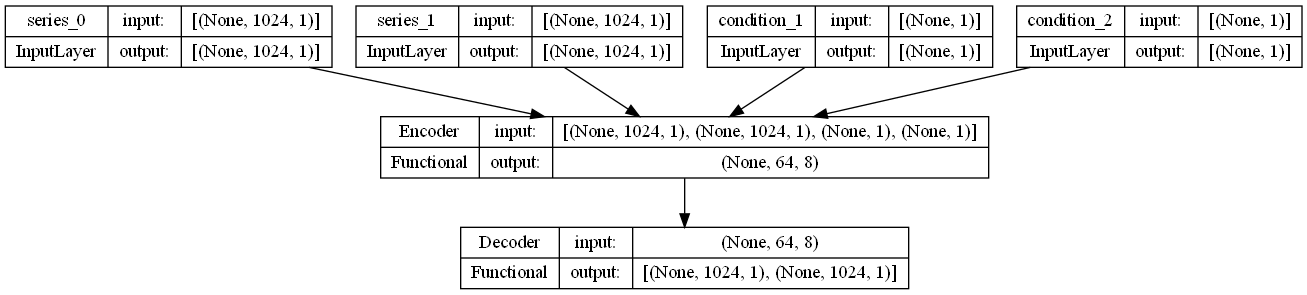

In [ ]:
plot_model(my_ccae_model_trained, to_file=os.path.join(model_folder_path,"model_structure", model_name.replace('.keras', '.png')), show_shapes=True, show_layer_names=True)
#
# plot_model(decoder, show_shapes=True, show_layer_names=True)

取出訓練資料 (健康模型)

In [ ]:

from sklearn.model_selection import train_test_split
from test_algs.CCAE_ntu_rul import data_augmentation
import random


# 分割 20% 資料作為驗證集 80% 資料作為訓練集
train_files = []
val_files = []

for folder in Normal_subfolders:
    parquet_files = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(".parquet")]
    # 如果資料夾中有多於一個 parquet 檔案，則隨機進行分割
    if len(parquet_files) > 1:
        train, val = train_test_split(parquet_files, test_size=0.2, random_state=42)
        train_files.extend(train)
        val_files.extend(val)
    elif len(parquet_files) == 1:
        train_files.extend(parquet_files)

# 打亂訓練資料順序，避免batch 中資料條件分布影響訓練結果
random.seed(42)
random.shuffle(train_files)
random.shuffle(val_files)
print(f"Train files: {len(train_files)}")
print(f"Validation files: {len(val_files)}")


Train files: 135
Validation files: 36


In [ ]:

from time import time
train_input_signals=[]
torque_conditions=[]
speed_conditions=[]

temp_torque=[]
temp_speed=[]
for file_path in train_files:
    if os.path.exists(file_path):
        
        # read the data
        df = read_rul_data(file_path)
        # print(df["Speed"][0])
        # time_now = time()
        # torque_v, _, _, _, _, _=estimate_torque(df, speed_v=df["Speed"][0], debug=False)
        # print(f"Torque estimation for {file_path} completed in {time() - time_now:.2f} seconds.")
        
        # 合併測試資料至訓練維度 shape=(,4000,dim)
        temp_train_input_signals = []
        for input_name in network_input_signal_names:
        # normalization
            raw_data=np.array(df[input_name])
            mean = np.mean(raw_data)
            standard = np.std(raw_data)
            normalized = (raw_data - mean) / standard  # 轉成 (1024, 1)
            augmented_data= data_augmentation(normalized, time_steps=sequence_length, window_size=10, cols=[0], random_seed=42)
            temp_train_input_signals.append(augmented_data) # normalization
            
            # 先做資料增強轉換至 (N*[(L-W)/1024+1], 1024, dim 維度)
            
        # 加入 train_input_signals
        train_input_signals.append(np.stack(temp_train_input_signals, axis=2))
        
        # 將條件擴展為 (temp_train_input_signals[0].shape[0], 1)
        torque_value_pu = np.array(df["Torque avg"]).reshape(-1)/ rated_torque
        speed_value_pu = np.array(df["Speed"]).reshape(-1) / rated_speed
        temp_torque.append(torque_value_pu[0])
        temp_speed.append(speed_value_pu[0])
        torque_expanded = np.full(temp_train_input_signals[0].shape[0], torque_value_pu[0])
        speed_expanded = np.full(temp_train_input_signals[0].shape[0], speed_value_pu[0])
        torque_conditions.append(torque_expanded)
        speed_conditions.append(speed_expanded)
        
    else:
        print(f"File {file_path} does not exist.")
        
train_input_signals = np.concatenate(train_input_signals,axis=0).astype(np.float32)
torque_conditions = np.concatenate(torque_conditions, axis=0).astype(np.float32)
speed_conditions = np.concatenate(speed_conditions, axis=0).astype(np.float32)


In [ ]:
train_input_signals.shape
my_ccae_model_trained.summary()

Model: "GRUAE_model2_in_2_out"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 series_0 (InputLayer)          [(None, 1024, 1)]    0           []                               
                                                                                                  
 series_1 (InputLayer)          [(None, 1024, 1)]    0           []                               
                                                                                                  
 condition_1 (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 condition_2 (InputLayer)       [(None, 1)]          0           []                               
                                                                              

模型訓練

Model CCAE_I2_in_I2_out_GRU_rpeat_condition_1024.keras exists, loading the model.
Model CCAE_I2_in_I2_out_GRU_rpeat_condition_1024.keras loaded successfully.
Model CCAE_I2_in_I2_out_GRU_rpeat_condition_1024.keras has not been trained yet, proceeding with training.
Epoch 1/20
1178/1178 [==============================] - 121s 99ms/step - loss: 0.0326 - Decoder_loss: 0.0180 - Decoder_1_loss: 0.0146 - val_loss: 0.0047 - val_Decoder_loss: 0.0033 - val_Decoder_1_loss: 0.0014
Epoch 2/20
1178/1178 [==============================] - 115s 98ms/step - loss: 0.0031 - Decoder_loss: 0.0018 - Decoder_1_loss: 0.0013 - val_loss: 0.0025 - val_Decoder_loss: 0.0014 - val_Decoder_1_loss: 0.0010
Epoch 3/20
1178/1178 [==============================] - 116s 99ms/step - loss: 0.0025 - Decoder_loss: 0.0014 - Decoder_1_loss: 0.0011 - val_loss: 0.0020 - val_Decoder_loss: 0.0011 - val_Decoder_1_loss: 8.7834e-04
Epoch 4/20
1178/1178 [==============================] - 116s 98ms/step - loss: 0.0022 - Decoder_loss: 0.

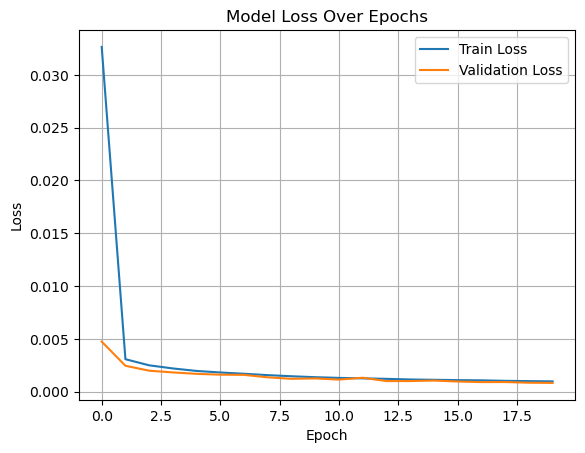

In [ ]:
import time
import tensorflow as tf
import tensorflow.keras.backend as K
import gc


def CCAE_train(keras_model, model_type: str, input_data, condition1_data, condition2_data, epochs=20, batch_size=10, use_cpu=False):
    # condition1_data, condition2_data shape: (N,) or (N, 1)
    if condition1_data.ndim == 1:
        condition1_data = condition1_data.reshape(-1, 1)
    if condition2_data.ndim == 1:
        condition2_data = condition2_data.reshape(-1, 1)

    # split train/val
    train_data, val_data, train_cond1, val_cond1, train_cond2, val_cond2 = train_test_split(
        input_data, condition1_data, condition2_data, test_size=0.2, random_state=38, shuffle=True
    )

    # 拆分 input/output
    if model_type == 'I2_in_I2_out':
        train_input = [train_data[:, :, i] for i in range(input_data.shape[2])]
        val_input = [val_data[:, :, i] for i in range(input_data.shape[2])]
        train_output = train_input.copy()
        val_output = val_input.copy()
    elif model_type == 'V2_in_I2_out':
        train_input = [train_data[:, :, i] for i in range(2)]
        val_input = [val_data[:, :, i] for i in range(2)]
        train_output = [train_data[:, :, i] for i in range(2, 4)]
        val_output = [val_data[:, :, i] for i in range(2, 4)]
    elif model_type == 'V2I2_in_V2I2_out':
        train_input = [train_data[:, :, i] for i in range(input_data.shape[2])]
        val_input = [val_data[:, :, i] for i in range(input_data.shape[2])]
        train_output = train_input.copy()
        val_output = val_input.copy()
    else:
        raise ValueError("Unknown model_type")

    # condition 輸入兩份（不同）
    train_input += [train_cond1, train_cond2]
    val_input += [val_cond1, val_cond2]

    keras_model.compile(optimizer='Adam', loss='mse')

    if use_cpu:
        with tf.device('/CPU:0'):
            history = keras_model.fit(
                train_input, train_output,
                epochs=epochs,
                batch_size=batch_size,
                validation_data=(val_input, val_output)
            )
    else:
        history = keras_model.fit(
            train_input, train_output,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(val_input, val_output)
        )

    return keras_model, history


if os.path.exists(os.path.join(model_folder_path, "models", model_name)):
    
    # 如果模型已存在，則載入模型
    print(f"Model {model_name} exists, loading the model.")
    my_ccae_model_trained = load_model(os.path.join(model_folder_path, "models", model_name), compile=False)
    print(f"Model {model_name} loaded successfully.")
    
    # 讀取模型的 json metadata
    metadata_path = os.path.join(model_folder_path, "model_inform", model_name.replace('.keras', '_metadata.json'))
    with open(metadata_path, "r", encoding="utf-8") as f:
        model_metadata = json.load(f)
    
    #若非則重新訓練模型
    # --------------------模型訓練---------------------
    if  (not model_metadata.get("trained", False)) or model_retraining:
        print(f"Model {model_name} has not been trained yet, proceeding with training.")
        
        # 設定訓練屬性並儲存
        time_start = time.time()
        Labels = np.full(train_input_signals.shape[0], 1)
        epochs=20
        batch_size=64
        
        # 清理記憶體
        K.clear_session()
        gc.collect()
        my_ccae_model1_trained, train_history= CCAE_train(my_ccae_model_trained, model_type, train_input_signals,
                                                          torque_conditions, speed_conditions, epochs, batch_size, use_cpu=False)
        
        # 清理記憶體
        K.clear_session()
        gc.collect()
        my_ccae_model_trained.save(os.path.join(model_folder_path, "models", model_name))
        
        # 更新模型 metadata
        model_metadata["trained"] = True
        model_metadata["train_date"] = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        with open(os.path.join(model_folder_path,"model_inform", model_name.replace('.keras', '_metadata.json')), "w", encoding="utf-8") as f:
                json.dump(model_metadata, f, ensure_ascii=False, indent=4)

        print("Training complete, elpased time:", time.time() - time_start)
        print(f"Model {model_name} trained and saved successfully.")

        # 繪製 Loss
        plt.figure()
        plt.plot(train_history.history['loss'], label='Train Loss')
        plt.plot(train_history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Model Loss Over Epochs')
        plt.legend()

        
        plt.grid(True)
        plt.show()
else :
    # 如果模型不存在，則拋出錯誤
    raise FileNotFoundError(f"Model {model_name} does not exist in {os.path.join(model_folder_path, 'models')}.")

In [ ]:

val_input_signals=[]
val_torque_conditions=[]
val_speed_conditions=[]
# 取出增強訓練資料
for file_path in val_files:
    if os.path.exists(file_path):
        
        # read the data
        df = read_rul_data(file_path)
        
        # 合併測試資料至訓練維度 shape=(,4000,dim)
        temp_train_input_signals = []
        for input_name in network_input_signal_names:
        # normalization
            raw_data=np.array(df[input_name])
            mean = np.mean(raw_data)
            standard = np.std(raw_data)
            normalized = (raw_data - mean) / standard  # 轉成 (1024, 1)
            augmented_data= data_augmentation(normalized, time_steps=sequence_length, window_size=10, cols=[0], random_seed=42)
            temp_train_input_signals.append(augmented_data) # normalization
            
            # 先做資料增強轉換至 (N*[(L-W)/1024+1], 1024, dim 維度)
            
        # 加入 train_input_s
        # ignals
        val_input_signals.append(np.stack(temp_train_input_signals, axis=2))
        
        # 將條件擴展為 (temp_train_input_signals[0].shape[0], 1)
        speed_value_pu = np.array(df["Torque avg"]).reshape(-1)/ rated_torque
        speed_value_pu = np.array(df["Speed"]).reshape(-1) / rated_speed
        torque_expanded = np.full(temp_train_input_signals[0].shape[0], speed_value_pu[0])
        speed_expanded = np.full(temp_train_input_signals[0].shape[0], speed_value_pu[0])
        val_torque_conditions.append(torque_expanded)
        val_speed_conditions.append(speed_expanded)
        
    else:
        print(f"File {file_path} does not exist.")
        
val_input_signals_all_type = np.concatenate(val_input_signals,axis=0)
val_torque_conditions = np.concatenate(val_torque_conditions, axis=0)
val_speed_conditions = np.concatenate(val_speed_conditions, axis=0)

# 準備模型輸入，針對不同模型類型進行處理
if model_type == 'I2_in_I2_out':
    val_input_signals_type=val_input_signals_all_type[:, :, : ]
    val_output_signals_type=val_input_signals_type.copy()
if model_type == 'V2_in_I2_out':
    val_input_signals_type=val_input_signals_all_type[:, :,:2 ] 
    val_output_signals_type=val_input_signals_all_type[:, :,2:4 ] 
elif model_type == 'V2I2_in_V2I2_out':
    val_input_signals_type=val_input_signals_all_type
    val_output_signals_type=val_input_signals_type.copy()
    
training_validation_result = my_ccae_model_trained.predict(
    [val_input_signals_type[:, :, i] for i in range(val_input_signals_type.shape[2])] + 
    [val_torque_conditions, val_speed_conditions],
    batch_size=128,  # ⚠ 減少 batch size
    verbose=1
)

197/197 [==============================] - 9s 44ms/step


驗證重建結果

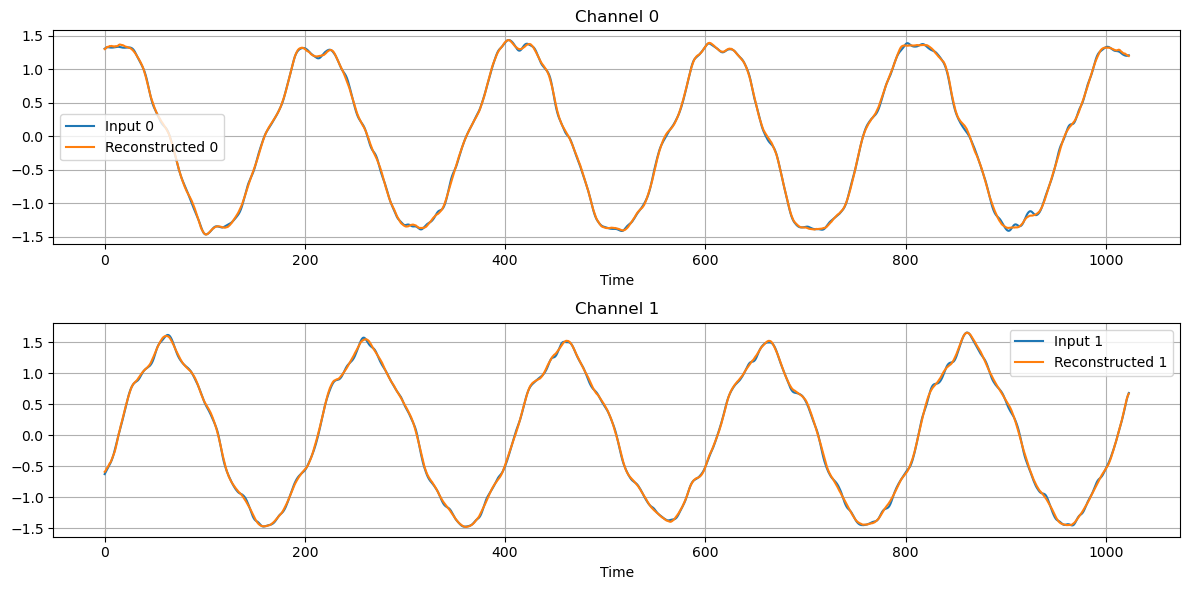

In [ ]:
# 取出第一筆驗證資料的輸入與重建結果，根據 channel 數自動繪圖
idx = 0
num_channels = val_output_signals_type.shape[2]
plt.figure(figsize=(12, 3 * num_channels))

for ch in range(num_channels):
    input_ch = val_output_signals_type[idx, :, ch]
    recon_ch = training_validation_result[ch][idx, :, 0]
    plt.subplot(num_channels, 1, ch + 1)
    plt.plot(input_ch, label=f'Input {ch}')
    plt.plot(recon_ch, label=f'Reconstructed {ch}')
    plt.title(f'Channel {ch}')
    plt.xlabel('Time')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
import random
import tensorflow as tf
import gc

def apply_model_to_all_ciondition(Normal_data_path, sample_factor):

    # 取得 Normal_data_path 下所有子資料夾
    subfolders = [f.path for f in os.scandir(Normal_data_path) if f.is_dir()]
   
    mse_results = {}

    for folder in subfolders:
        # 取得該子資料夾下所有 parquet 檔案
        parquet_files = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(".parquet")]
        if len(parquet_files) == 0:
            continue
        # 隨機選取 50% 檔案
        random.shuffle(parquet_files)
        # 用 0.5 比例隨機採樣
        num_select = max(1, int(len(parquet_files) * sample_factor))
        selected_files = random.sample(parquet_files, num_select)
        folder_mses = []
        
        apply_input_signals=[]
        apply_torque_conditions=[]
        apply_speed_conditions=[]
        
        for file_path in selected_files:
            df = read_rul_data(file_path)
            # 依據 network_input_signal_names 做 normalization 並切片
            temp_signals = []
            for input_name in network_input_signal_names:
                raw_data = np.array(df[input_name])
                mean = np.mean(raw_data)
                std = np.std(raw_data)
                normalized = (raw_data - mean) / std
                augmented_data= data_augmentation(normalized, time_steps=sequence_length, window_size=10, cols=[0], random_seed=42)
                temp_signals.append(augmented_data) # normalization
            # shape: (num_slices, 1024, num_channels)
            
            # 加入 train_input_signals
            apply_input_signals.append(np.stack(temp_signals, axis=2))
                
            # 將條件擴展為 (temp_train_input_signals[0].shape[0], 1)
            torque_value_pu = np.array(df["Torque avg"]).reshape(-1) / rated_torque
            torque_value_pu = np.array(df["Speed"]).reshape(-1) / rated_speed
            torque_expanded = np.full(apply_input_signals[0].shape[0], torque_value_pu[0])
            speed_expanded = np.full(apply_input_signals[0].shape[0], torque_value_pu[0])
            apply_torque_conditions.append(torque_expanded)
            apply_speed_conditions.append(speed_expanded)
        
        apply_input_signals = np.concatenate(apply_input_signals,axis=0)
        apply_torque_conditions = np.concatenate(apply_torque_conditions, axis=0)
        apply_speed_conditions = np.concatenate(apply_speed_conditions, axis=0)
        
        # 準備模型輸入，針對不同模型類型進行處理
        if model_type == 'I2_in_I2_out':
            predict_input_signals_type=apply_input_signals[:, :, : ]
        if model_type == 'V2_in_I2_out':
            predict_input_signals_type=apply_input_signals[:, :,:2 ] 
        elif model_type == 'V2I2_in_V2I2_out':
            predict_input_signals_type=apply_input_signals
        
        # 單位為同一資料夾之資料不須和外合併，直接預測
        # with tf.device('/CPU:0'):
        preds_per_condition = my_ccae_model_trained.predict([predict_input_signals_type[:, :, i] for i in range(predict_input_signals_type.shape[2])] + [apply_torque_conditions, apply_speed_conditions],
                                                                batch_size=128, verbose=2)
        tf.keras.backend.clear_session()
        gc.collect()
        # 計算每個 condition 下的 MSE（不合併，保留原始資料集）
        mses_per_condition = []
        for i in range(len(preds_per_condition)):
            mse = np.mean((preds_per_condition[i].squeeze() - apply_input_signals[:, :, i]) ** 2, axis=1)
            mses_per_condition.append(mse)
        # mses_per_condition: list，每個元素 shape=(num_samples,)
        folder_mses.append(mses_per_condition)
        # 將資料夾名稱前面的日期與底線去掉
        folder_name = os.path.basename(folder)
        # 假設格式為 "0529_1200_0_5V"，去掉前面的 "0529_"
        if "_" in folder_name:
            folder_name = folder_name.split("_", 1)[1]
            
        mse_results[folder_name] = folder_mses
        
    return mse_results


sample_factor=0.25

Normal_mse_results = apply_model_to_all_ciondition(os.path.join(NTU_dataset_path, 'Normal'), sample_factor)
# 將所有 mse results 組成一個 dict，方便後續統一處理
verify_mse_results = {
    "Normal": Normal_mse_results,
    "Cut_2mm": apply_model_to_all_ciondition(os.path.join(NTU_dataset_path, 'Cut_2mm'), sample_factor),
    "drill_1X2": apply_model_to_all_ciondition(os.path.join(NTU_dataset_path, 'drill 1X2'), sample_factor),
    "drill_2X1": apply_model_to_all_ciondition(os.path.join(NTU_dataset_path, 'drill 2X1'), sample_factor),
    # "drill_2X2": apply_model_to_all_ciondition(os.path.join(NTU_dataset_path, 'drill 2X2'), sample_factor),
    "Normal1": apply_model_to_all_ciondition(os.path.join(NTU_dataset_path, 'Normal1'), sample_factor),
    "Normal2": apply_model_to_all_ciondition(os.path.join(NTU_dataset_path, 'Normal2'), sample_factor),
    "Wearout1": apply_model_to_all_ciondition(os.path.join(NTU_dataset_path, 'Wearout1'), sample_factor),
    "Wearout2": apply_model_to_all_ciondition(os.path.join(NTU_dataset_path, 'Wearout2'), sample_factor),
}



22/22 - 1s - 961ms/epoch - 44ms/step
22/22 - 1s - 1s/epoch - 53ms/step
22/22 - 1s - 1s/epoch - 53ms/step
22/22 - 1s - 1s/epoch - 54ms/step
28/28 - 1s - 1s/epoch - 52ms/step
22/22 - 1s - 1s/epoch - 55ms/step
22/22 - 1s - 1s/epoch - 53ms/step
22/22 - 1s - 1s/epoch - 54ms/step
22/22 - 1s - 1s/epoch - 53ms/step
22/22 - 1s - 1s/epoch - 54ms/step
22/22 - 1s - 1s/epoch - 55ms/step
22/22 - 1s - 1s/epoch - 54ms/step
22/22 - 1s - 1s/epoch - 53ms/step
22/22 - 1s - 1s/epoch - 50ms/step
22/22 - 1s - 1s/epoch - 56ms/step
11/11 - 1s - 611ms/epoch - 56ms/step
22/22 - 1s - 1s/epoch - 53ms/step
22/22 - 1s - 1s/epoch - 55ms/step
22/22 - 1s - 1s/epoch - 54ms/step
22/22 - 1s - 1s/epoch - 53ms/step
22/22 - 1s - 1s/epoch - 53ms/step
22/22 - 1s - 1s/epoch - 54ms/step
22/22 - 1s - 1s/epoch - 53ms/step
22/22 - 1s - 1s/epoch - 53ms/step
22/22 - 1s - 1s/epoch - 54ms/step
22/22 - 1s - 1s/epoch - 53ms/step
22/22 - 1s - 1s/epoch - 53ms/step
28/28 - 1s - 1s/epoch - 52ms/step
22/22 - 1s - 1s/epoch - 52ms/step
22/22 - 

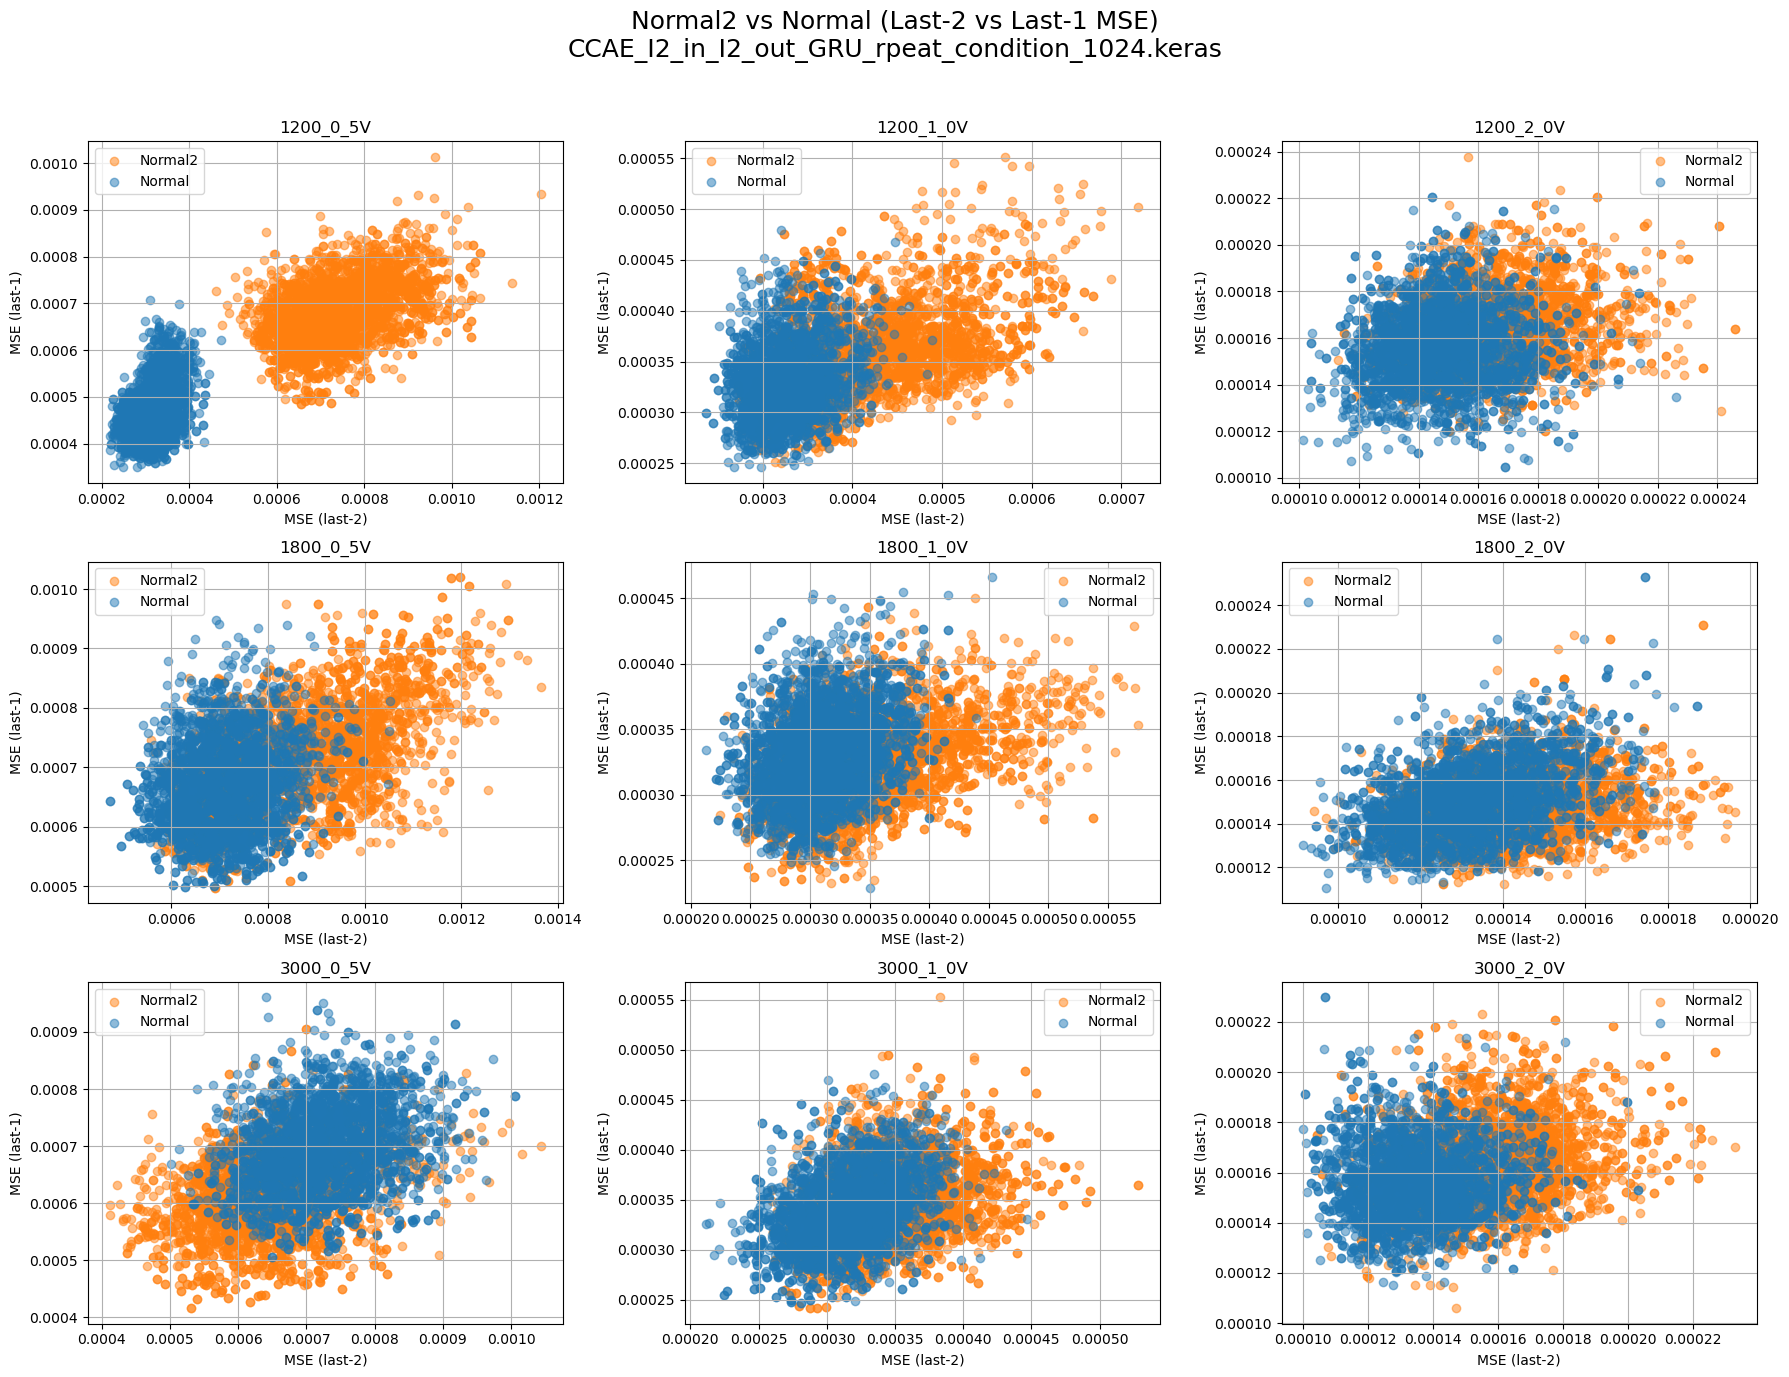

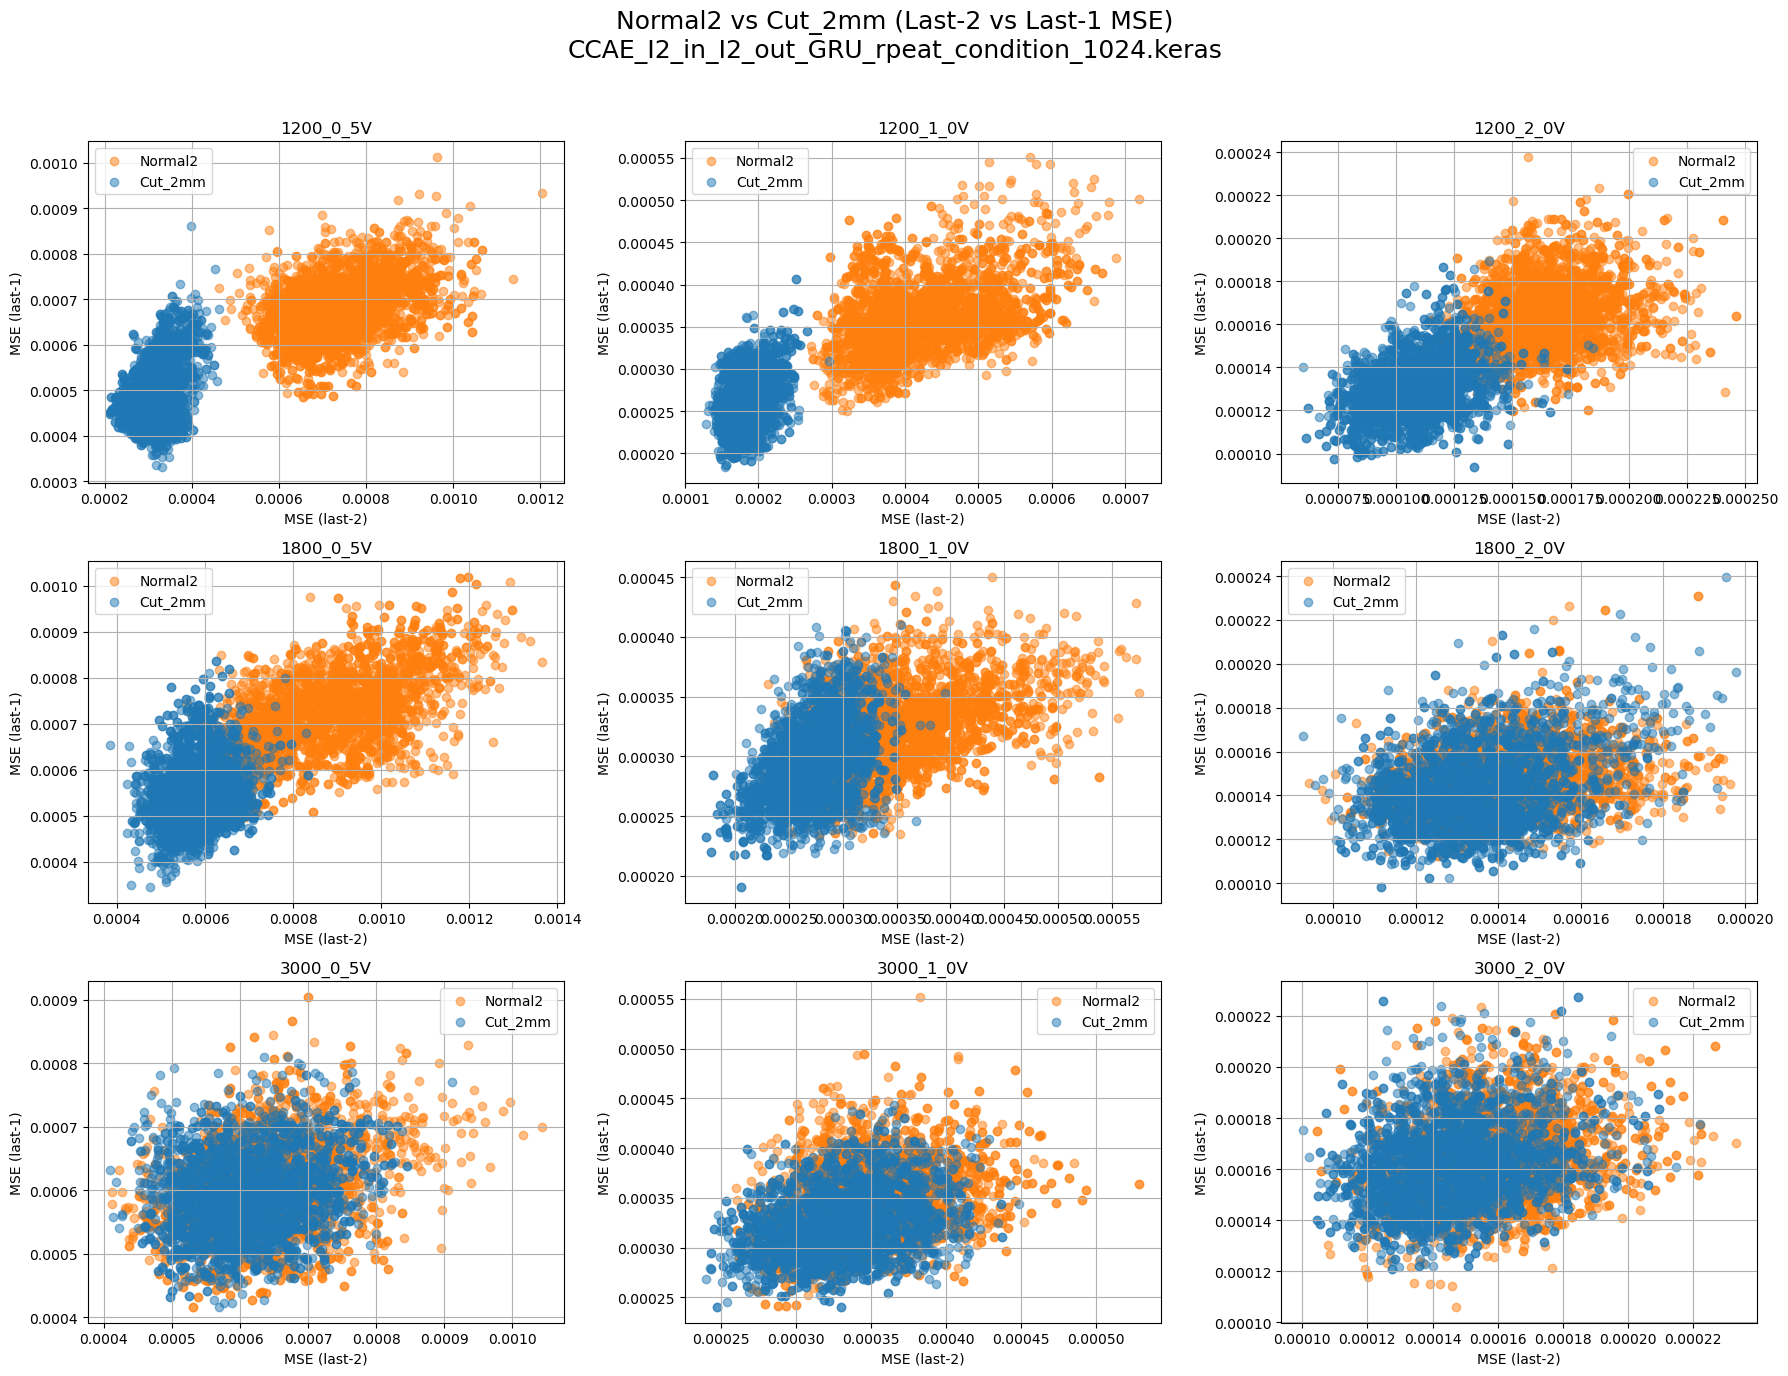

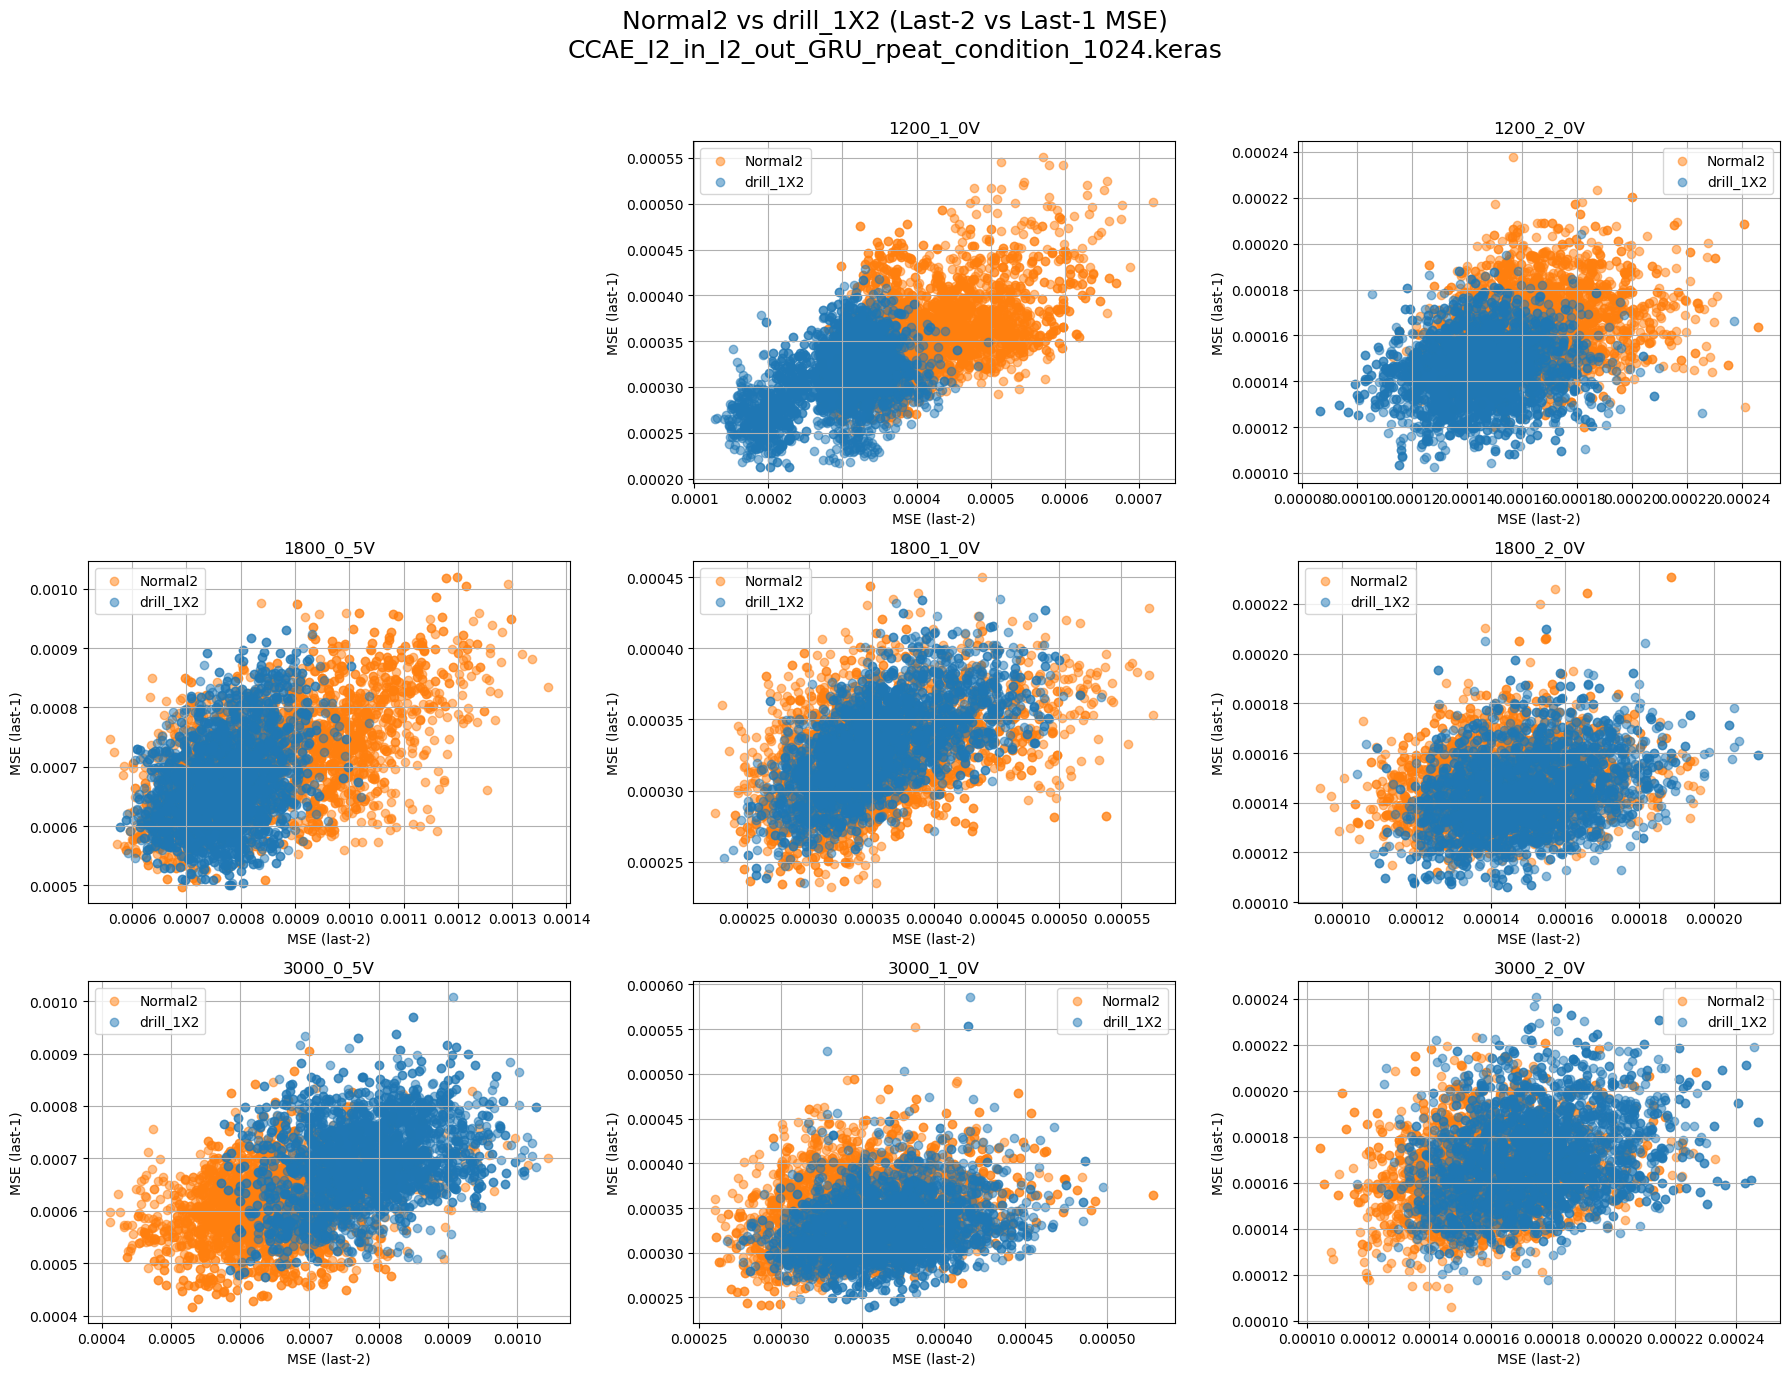

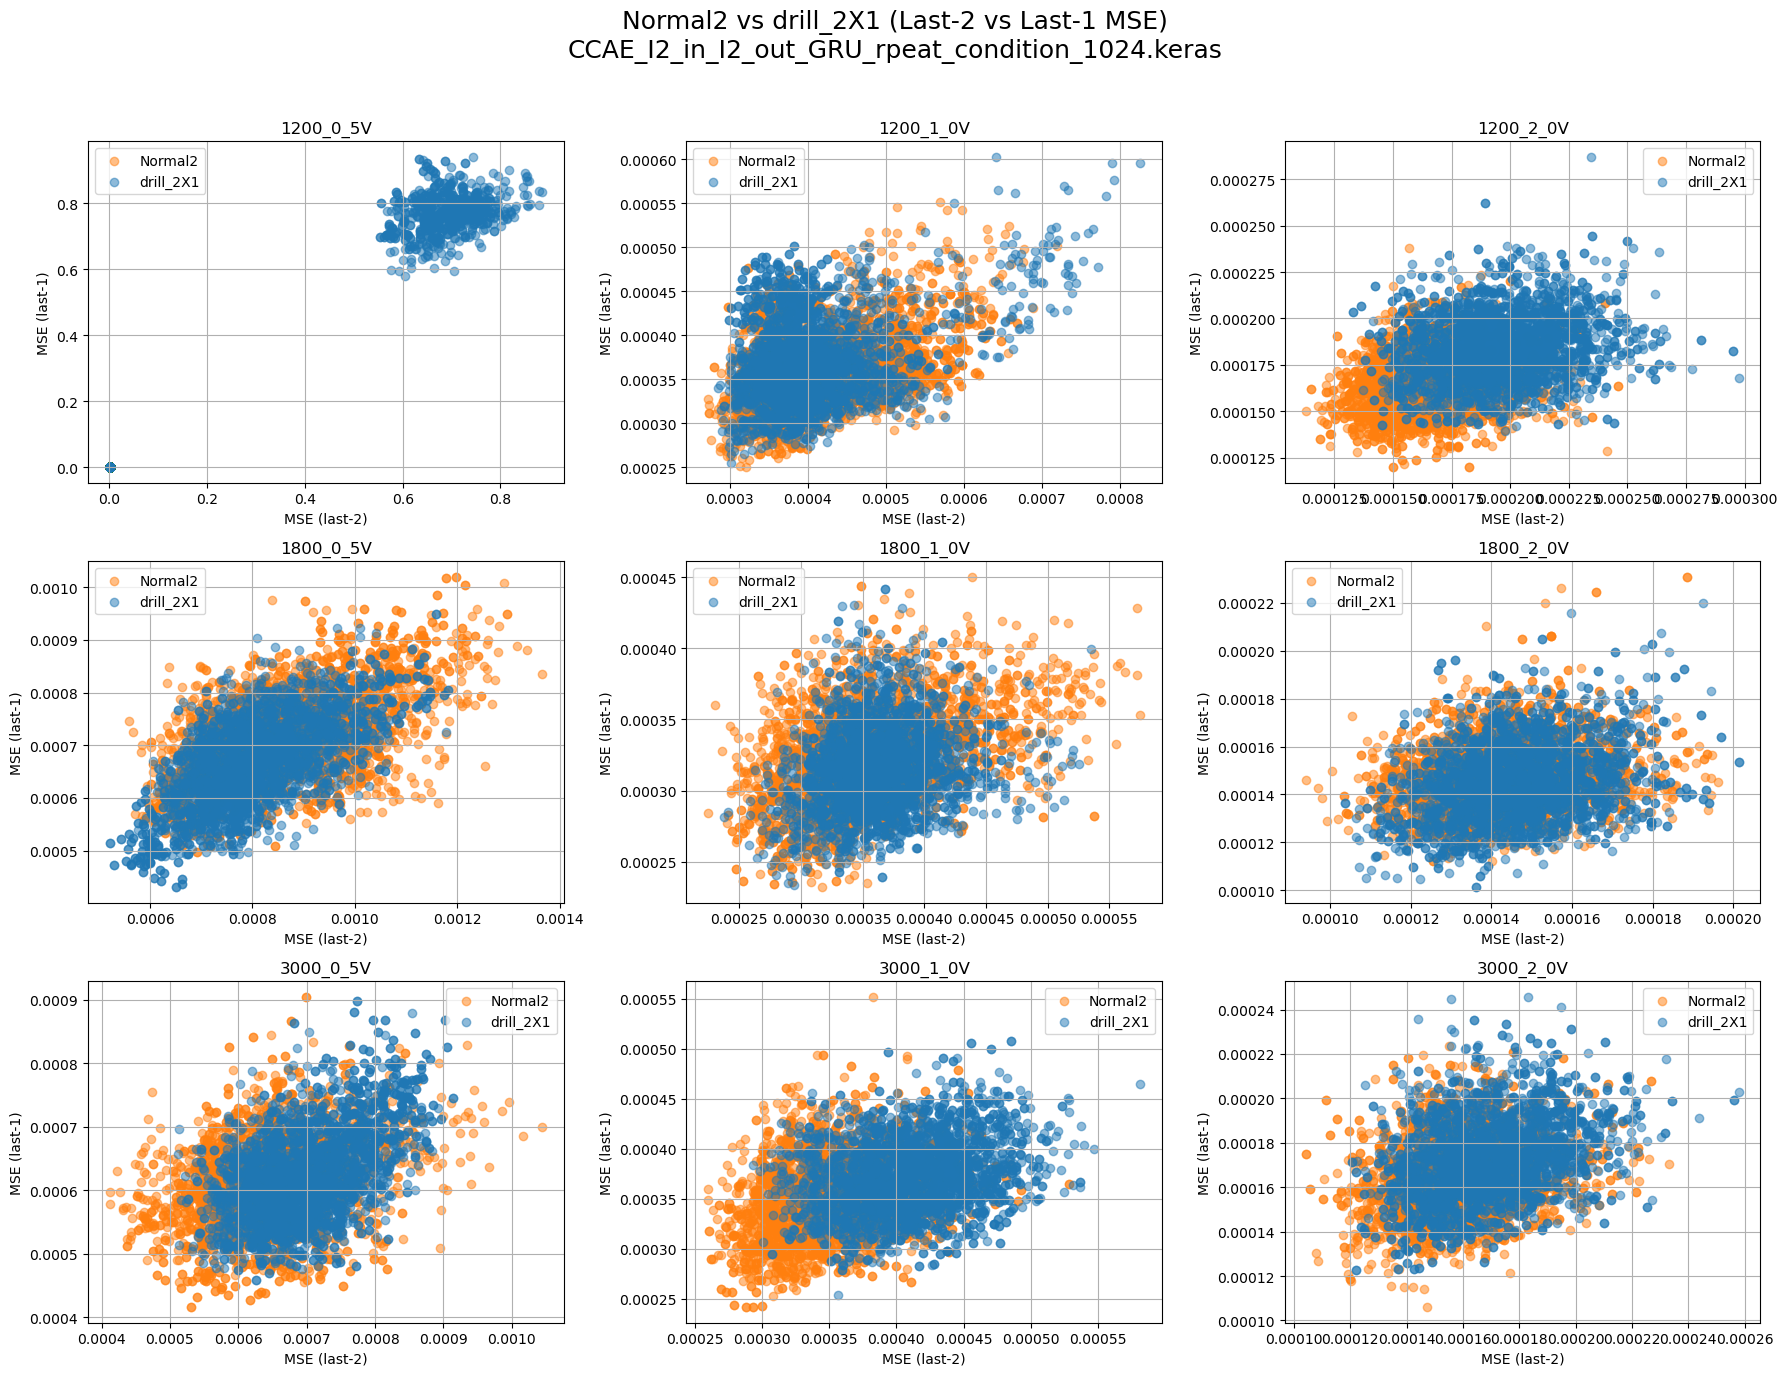

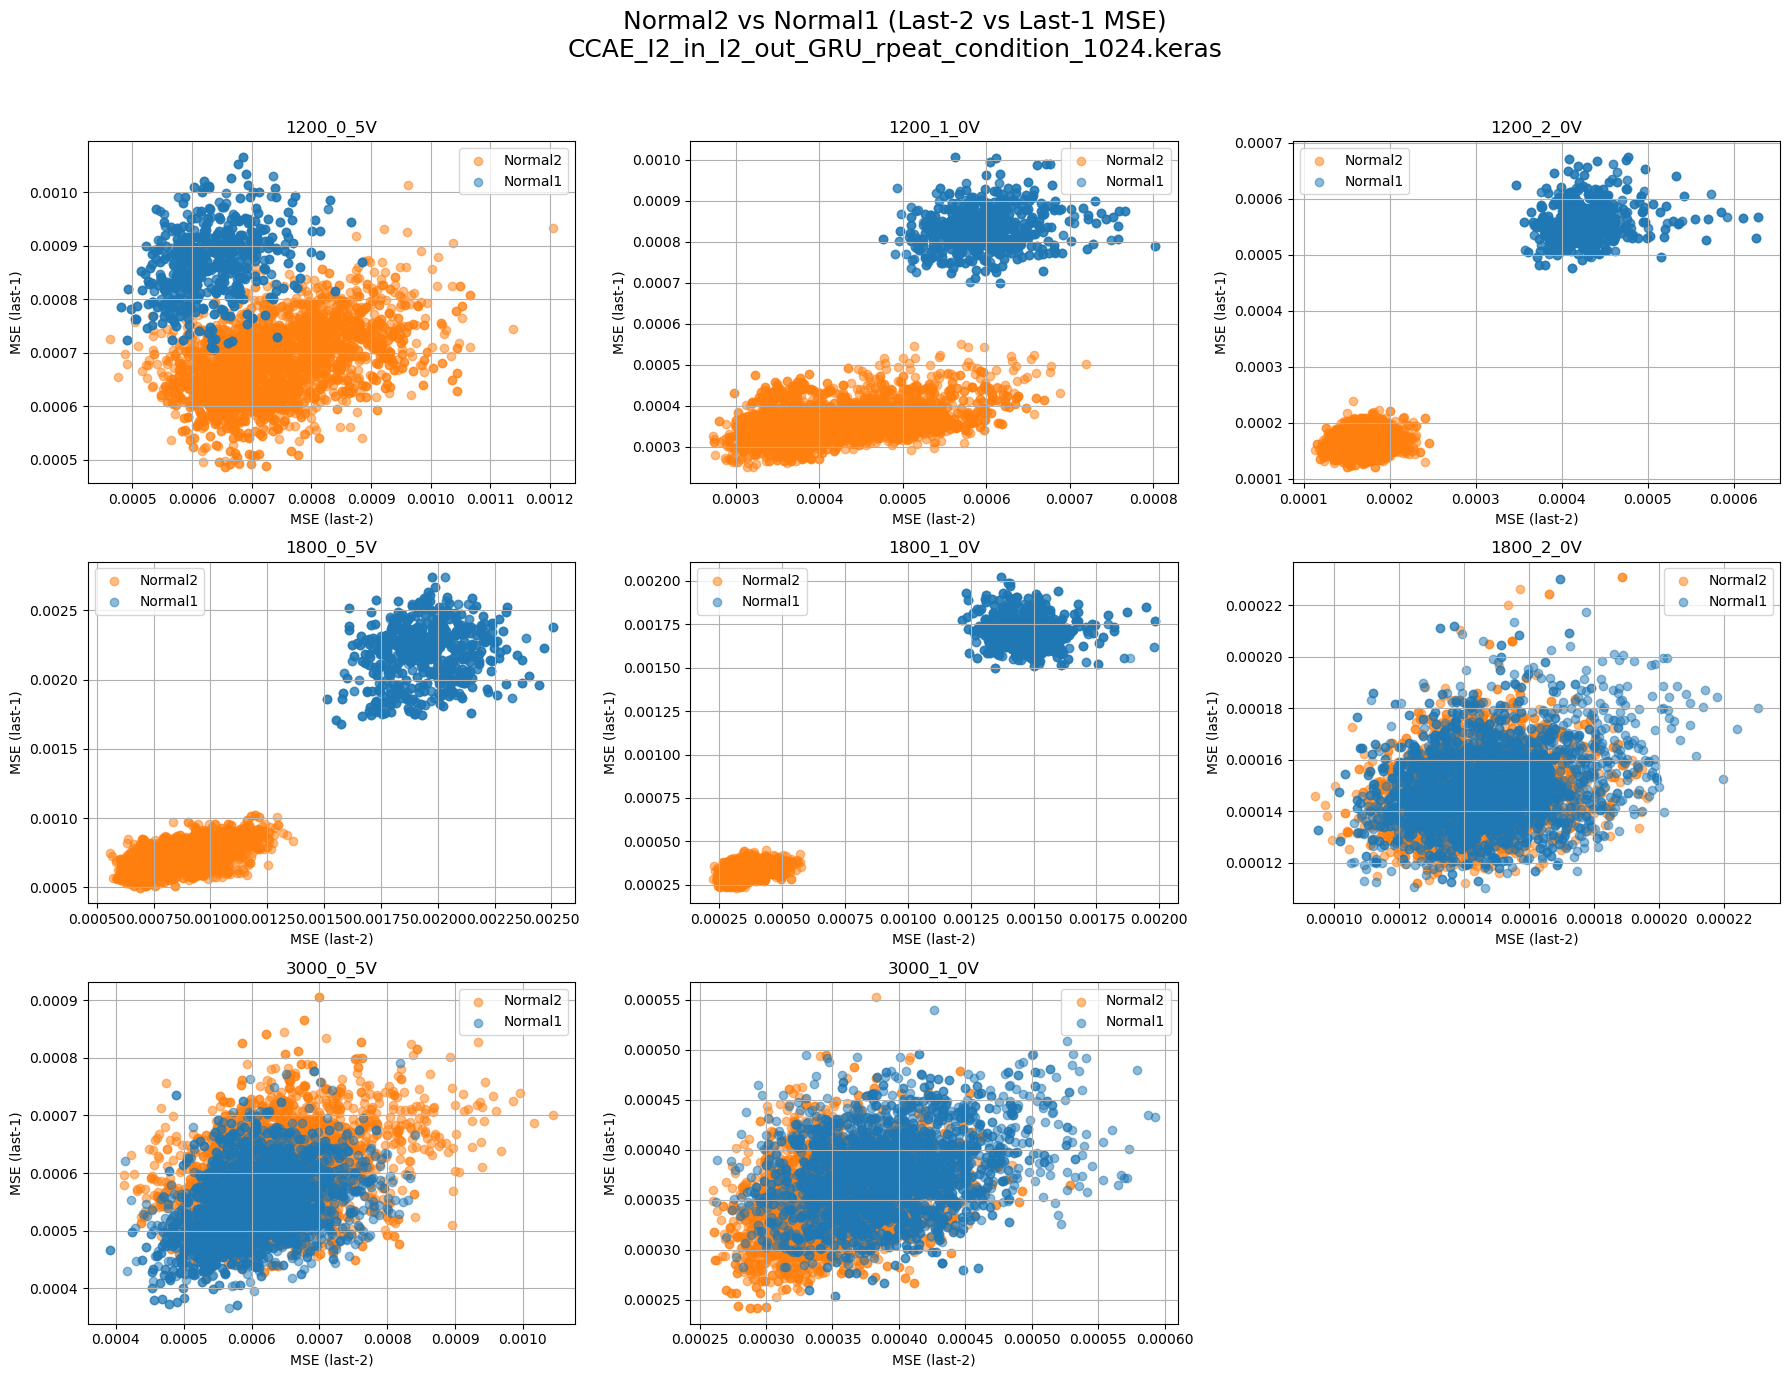

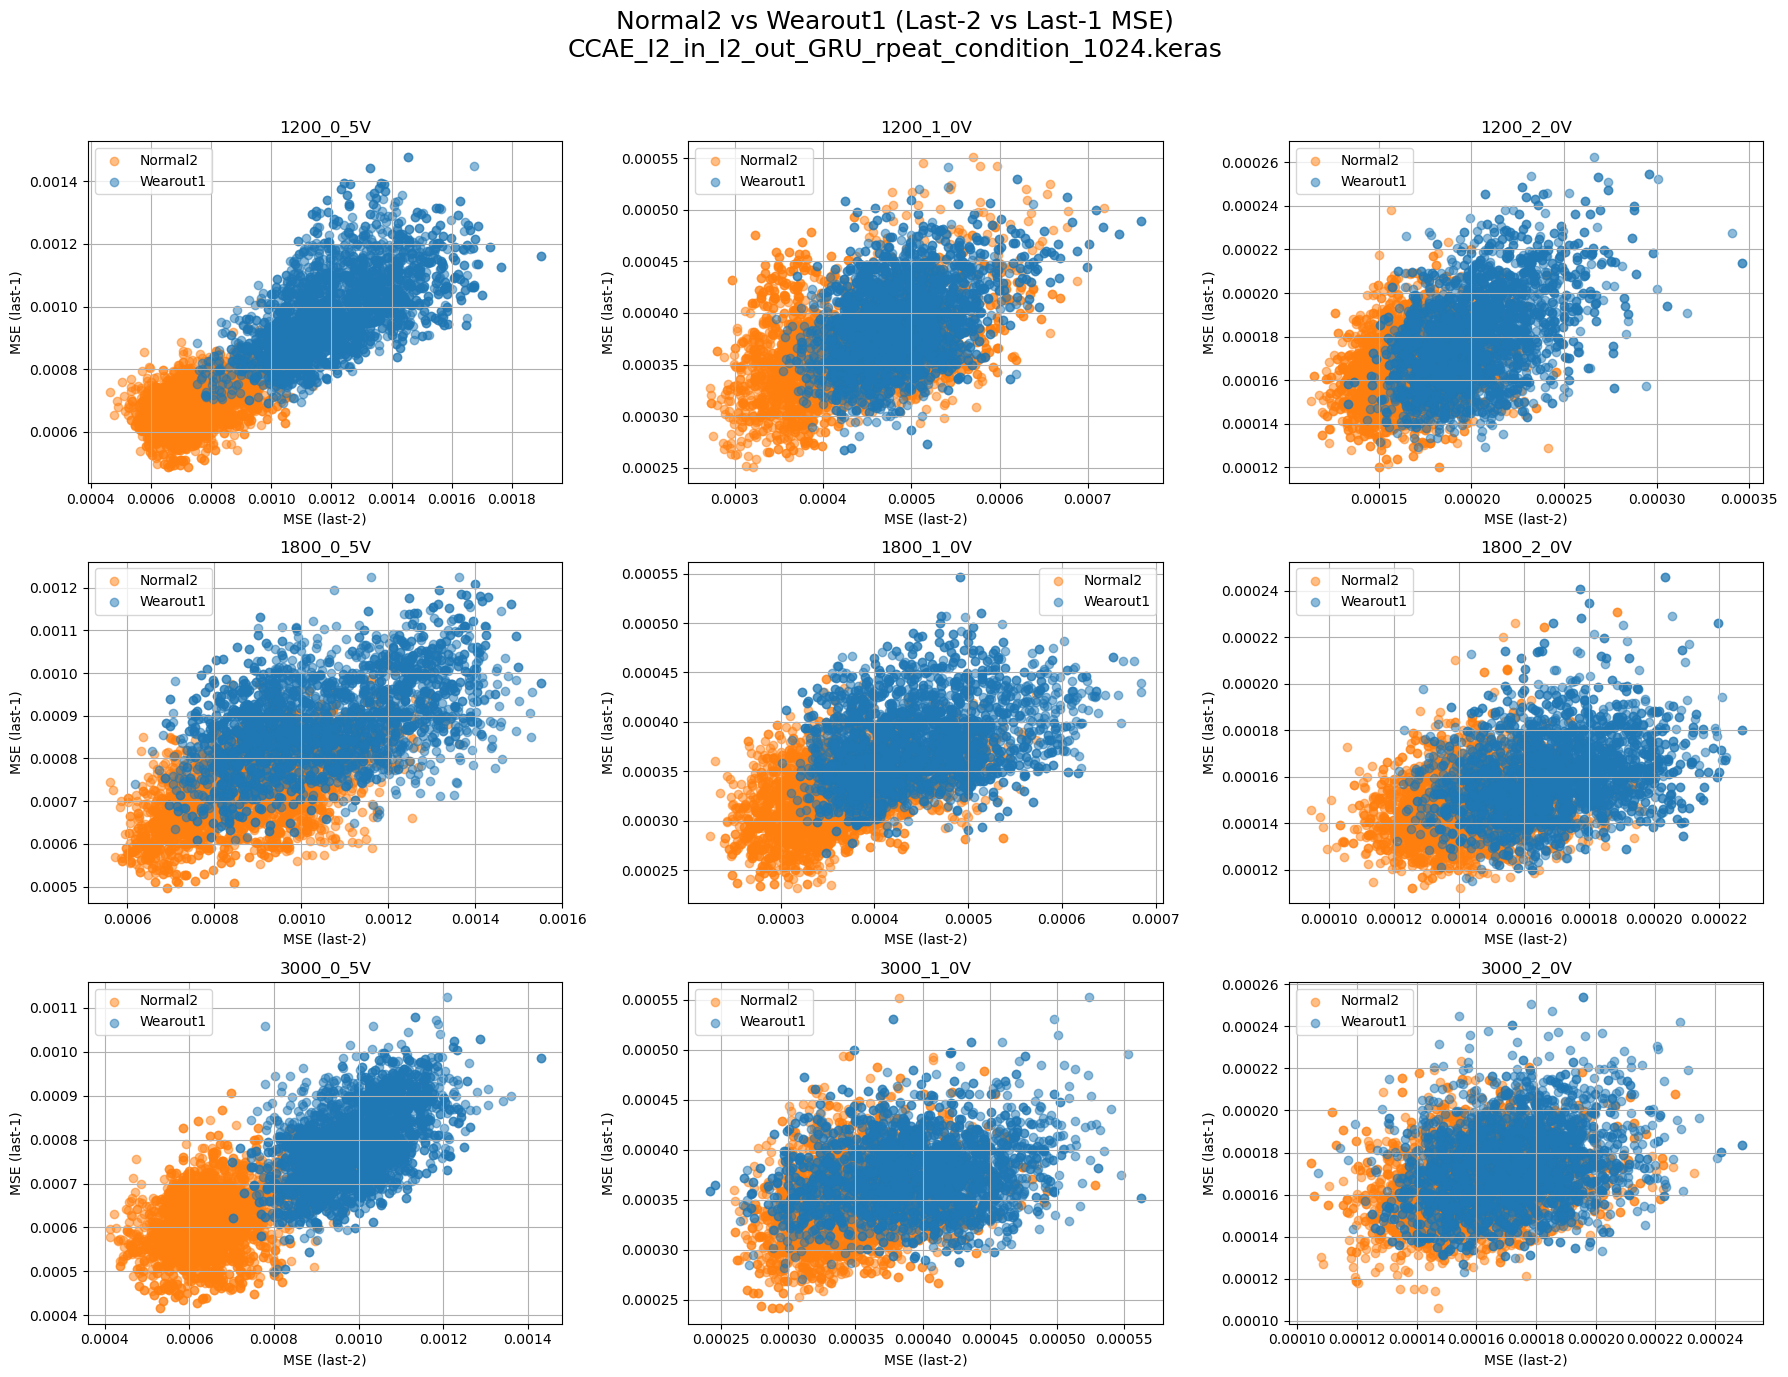

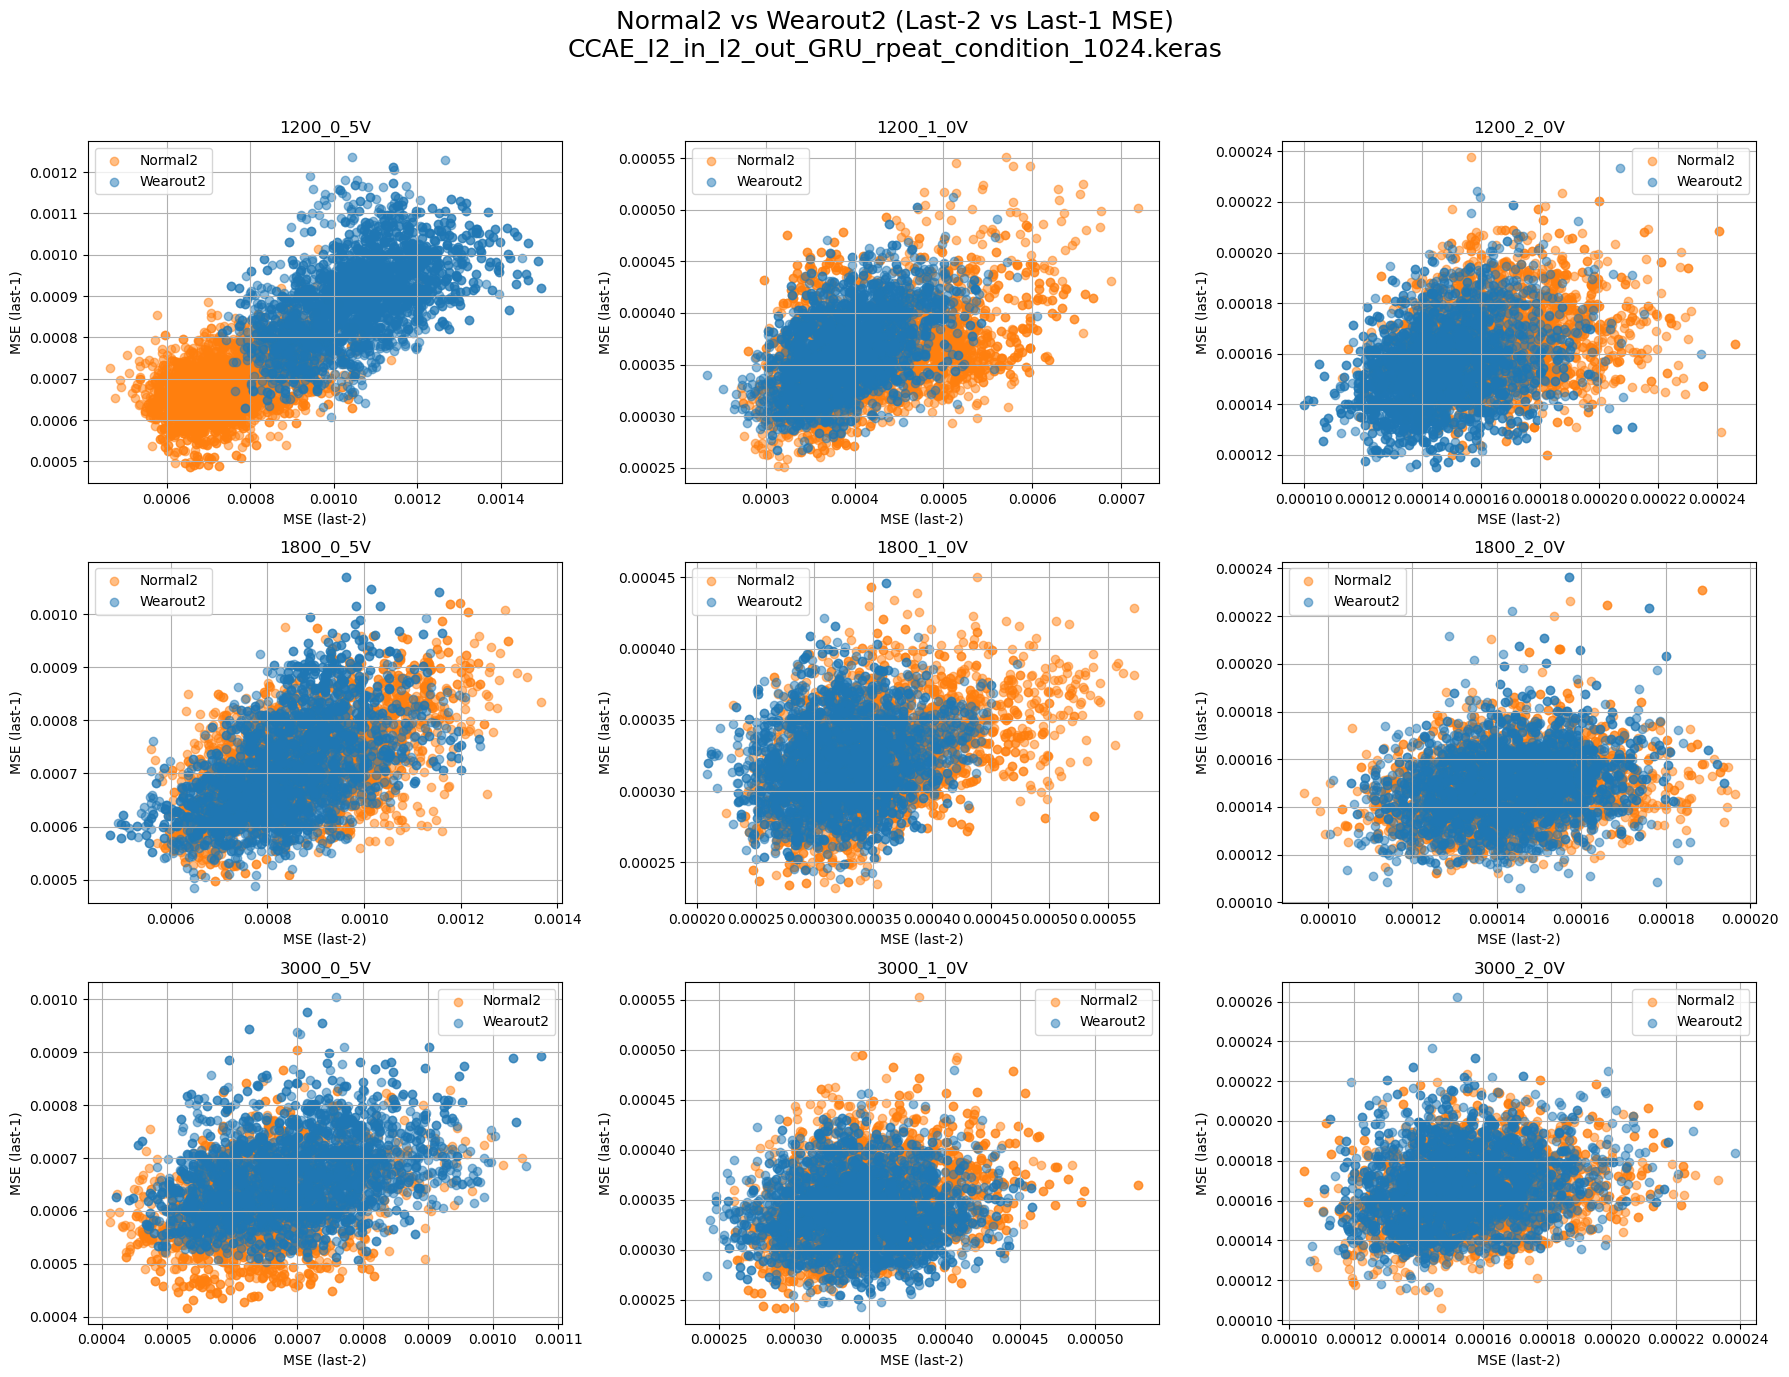

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 比較所有 verify_mse_results 的 xy 分布（last-2 vs last-1 MSE），每個 condition 都和 Normal 做比較
golden_sample="Normal2"  # 用 Normal2 作為 golden sample
normal_dict = verify_mse_results[golden_sample]
folders = list(normal_dict.keys())
num_folders = len(folders)
num_figs = int(np.ceil(num_folders / 9))

for condition, cond_dict in verify_mse_results.items():
    if condition == golden_sample:
        continue  # 跳過自己比自己
    for fig_idx in range(num_figs):
        fig, axes = plt.subplots(3, 3, figsize=(18, 14))
        fig.suptitle(f"{golden_sample} vs {condition} (Last-2 vs Last-1 MSE)\n{model_name}", fontsize=18)
        for i in range(9):
            folder_idx = fig_idx * 9 + i
            if folder_idx >= num_folders:
                axes.flat[i].set_visible(False)
                continue
            folder = folders[folder_idx]
            ax = axes.flat[i]
            # 取 Normal mse
            if folder in normal_dict and folder in cond_dict:
                mse_arrays_normal = normal_dict[folder][0]
                mse_arrays_cond = cond_dict[folder][0]
                if len(mse_arrays_normal) >= 2 and len(mse_arrays_cond) >= 2:
                    x_normal = mse_arrays_normal[-2].flatten()
                    y_normal = mse_arrays_normal[-1].flatten()
                    x_cond = mse_arrays_cond[-2].flatten()
                    y_cond = mse_arrays_cond[-1].flatten()
                    ax.scatter(x_normal, y_normal, alpha=0.5, label=golden_sample, color='tab:orange')
                    ax.scatter(x_cond, y_cond, alpha=0.5, label=condition, color='tab:blue')
                    ax.set_xlabel("MSE (last-2)")
                    ax.set_ylabel("MSE (last-1)")
                    ax.set_title(folder)
                    ax.legend()
                    ax.grid(True)
                else:
                    ax.set_visible(False)
            else:
                ax.set_visible(False)
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()
        
        # 建立儲存資料夾
        save_dir = os.path.join("NTU_rul_models", "model_result", model_name)
        os.makedirs(save_dir, exist_ok=True)
        # 儲存圖檔
        fig_path = os.path.join(save_dir, f"{golden_sample}_vs_{condition}_part{fig_idx+1}.png")
        fig.savefig(fig_path)
        plt.close(fig)